# Analisis de datos

## Preparacion de los datos

### Liberias y DFs

In [628]:
#Importar librerias a usar
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
import plotly.express as px
import zepid
from zepid.graphics import EffectMeasurePlot
import networkx as nx
from numpy import genfromtxt
from scipy import stats
import os

In [629]:
# Reseteo del directorio principal
os.getcwd()
os.chdir("C:\\Users\someo\Downloads\Review_EDA_Emotion_Recognition")

In [630]:
#Creación de data frames a usar
df_metadata = pd.read_csv('.\data\Tabla Normalizada - Metadata.csv')
df_data_type = pd.read_csv('.\data\Tabla Normalizada - Data type.csv')
df_participants = pd.read_csv('.\data\Tabla Normalizada - Participants.csv')
df_self_report = pd.read_csv('.\data\Tabla Normalizada - Self report.csv')
df_emotion_elicitation_techniques = pd.read_csv('.\data\Tabla Normalizada - Emotion elicitation techniques.csv')
df_eda = pd.read_csv('.\data\Tabla Normalizada - EDA.csv')
df_statistical_learning_models = pd.read_csv('.\data\Tabla Normalizada - Statistical Learning model.csv')
df_performances = pd.read_csv('.\data\Tabla Normalizada - Performances.csv')
df_alg_perf = pd.read_csv('.\data\Tabla Normalizada - Alg_Perf.csv')

### Set características generales de los gráficos

In [631]:
plt.rcParams['figure.figsize'] = [20, 10]

sns.set_style("whitegrid")
sns.set_palette('colorblind')

plt.rcParams["legend.fontsize"] = 20
plt.rcParams["xtick.labelsize"] = 20
plt.rcParams["ytick.labelsize"] = 20
plt.rcParams["axes.labelsize"] = 20
plt.rcParams["axes.titlesize"] = 25

### Funciones
* multi_reversing = para casos donde un dato toma mas de valor, o en casos tipicos de one hot encoding (un dato toma un solo valor)
* multi_reversing_n = mismo que el anterior, pero para numeros distintos de cero
* bar_plot = funcion para crear plot de barras
* t_student = test estadistico t de student
* mann_whitney_u = test estadstico U de MannWhitney
* relaciones = utilizada para los grafos, para mostrar la cantidad de veces que aparecieron conexiones entre dimensiones / categorias con n numero de interacciones

In [632]:
def multi_reversing(df,col_id, col_values):
    """la funcion toma nos da la frecuencia de los datos distribuidos en distintas columnas.
    Toma una variable distribuida en varias columnas (one hot encoding), y aplica la funcion melt para cambiar el formato
    de la tabla a long. Luego devuelve una columna donde aparece el nombre de cada columna, la cantidad de veces que fue
    marcada con una 'x' (si accuracy fue marcada 50 veces, aparecera el str 'accuracy' 50 veces, lo que permite graficar su frecuencia
    de aparicion)

    Args:
        df (dataframe): dataframe con el que se desea trabajar, debe poseer las columnas de id_vars y list_value_vars
        in_id_vars (str): nombre de la columna que se usa como identificador de variables 
        value_vars (str o lista): str o lista con el nombre de las columnas de las cuales se desea obtener los datos (se puede
        obviamente subsetear (p.e. dataframe.iloc['columna_1',...,columna_n']))

    Returns:
        dataframe: _description_
    """
    df_raw = pd.melt(df, id_vars = col_id, value_vars = col_values)
    return df_raw[df_raw.value == 'x']

def multi_reversing_n(df,col_id, col_values):
    """exactamente lo mismo que multi_reversing, solo que para casos donde lo que se busca es un numero y no una x
    """
    df_raw = pd.melt(df, id_vars = col_id, value_vars = col_values)
    return df_raw[df_raw.value != 0]

def bar_plot(col, data, titulos):
    var_x = col
    df = data
    g = sns.countplot(x=var_x, data=df, order = getattr(df, var_x).value_counts().index)
    g.set(title = titulos[0], xlabel = titulos[1], ylabel = titulos[2])
    plt.xticks(rotation=90)
    
    plt.tight_layout()
    plt.savefig(f'.\\Emmanuel\\figures\\NUEVOS. {titulos[0]}.jpg', dpi=1000)
    plt.show()

def t_student(x,y):
	print('Students t-test')
	from scipy.stats import ttest_ind
	stat, p = ttest_ind(x, y, alternative = 'greater')
	print('stat=%.3f, p=%.3f' % (stat, p))
	if p > 0.05:
		print('Probably the same distribution')
	else:
		print('Probably different distributions')


def mann_whitney_u(x,y):
	print('Mann-Whitney U Test')
	from scipy.stats import mannwhitneyu
	stat, p = mannwhitneyu(x, y, alternative = 'greater')
	print('stat=%.3f, p=%.3f' % (stat, p))
	if p > 0.05:
		print('Probably the same distribution')
	else:
		print('Probably different distributions')

def relaciones(weight):
    df_weights_dim = pd.DataFrame(weight)
    wserie = df_weights_dim.value_counts()
    wserie = wserie.to_frame()
    wserie.index.names = ['index']
    wserie.rename(columns = {0:'relations'}, inplace = True)
    wserie = wserie.reset_index()
    
    col1 = wserie.columns[0]
    col2 = wserie.columns[1]

    # iterar sobre las filas del dataframe
    for i, row in wserie.iterrows():
        print(f"Interacciones con {row[col1]} conexiones se observaron {row[col2]/2} veces.")


## Analisis (graficos)
* La lista de los gráficos:
    * Cantidad de papers por año (2010 - 2020) segun tipo de modelo emocional
    * Algoritmos mas usados para modelos de clasificacion dimensionales (inputs HA, LA y HV, LV)
    * Comparación de medidas de performance por anio
    * Comparación de medidas de performance por anio, para valence y arousal
    * Cantidad de modelos de regresion y clasificacion por año (2010 - 2020)
    * Frecuencia uso categorias emocionales
    * Grafos categorias emocionales:
        - Conexiones entre categorias emocionales
        - Conexiones entre categorias emocionales - Numero de relaciones
        - Conexiones entre categorias emocionales - Grosor segun numero de relaciones
    * Grafos dimensiones emocionales:
        - Conexiones entre dimensiones emocionales
        - Conexiones entre dimensiones emocionales - Numero de relaciones
        - Conexiones entre dimensiones emocionales - Grosor segun numero de relaciones
    * Cantidad de modelos de tipo regressor
    * Cantidad de modelos de tipo classifier
    * Cantidad de modelos de tipo classifier y regressor
    * Los 10 algoritmos mas usados
    * Proporcion uso de modelos de regresion y clasificacion
    * Frecuencia de uso de bases de datos públicas y privadas por año (2010 - 2020)
    * Frecuencia de uso de bases de datos públicas
    * Cantidad de papers por journal
    * Cantidad de papers por journal (Others=1)

### ¿Cual es la evolucion temporal (2010-2020) del uso de los modelos emocionales empleados (categoriales o dimensionales)?

Gráfico de barra por año (2010-2020) por paper según modelos de emociones empleado (categoriales o dimensionales)

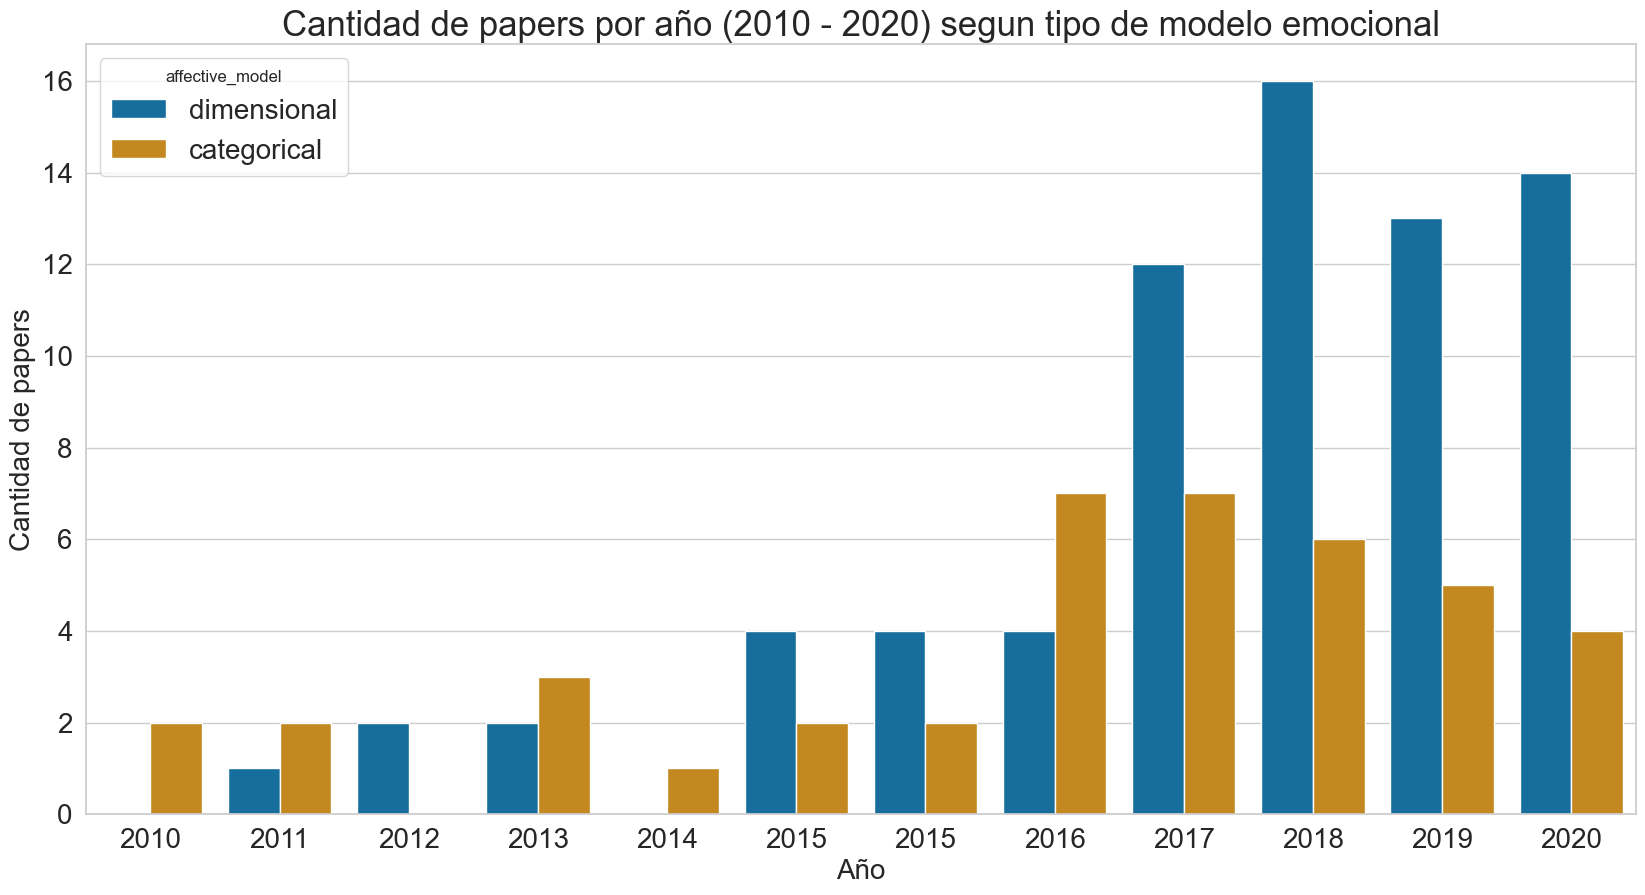

In [633]:
#rellenar datos faltantes y NO SE DROPEAN los duplicados (hay papers que usan multiples modelos)
df_statistical_learning_models=df_statistical_learning_models.fillna('-')
df_statistical_learning_models=df_statistical_learning_models[df_statistical_learning_models['affective_model'].isin(['categorical', 'dimensional'])]
df_statistical_learning_models_0 = df_statistical_learning_models.groupby(['paper_id','affective_model']).nth(0)
df_statistical_learning_models_0.reset_index(inplace=True)

#ploteo
category_order = [2010, 2011, 2012, 2013, 2014, 2015, 2015, 2016, 2017, 2018, 2019, 2020]
g= sns.countplot(x='year', 
    data= df_statistical_learning_models_0, 
    hue='affective_model', 
    order=category_order)
g.set(title = 'Cantidad de papers por año (2010 - 2020) segun tipo de modelo emocional', xlabel = 'Año', ylabel = 'Cantidad de papers')
plt.savefig('.\\Emmanuel\\figures\\NUEVOS. Cantidad de papers por año (2010-2020) segun tipo de modelo emocional.png')

### ¿Los modelos de clasificacion dimensionales basados en arousal performan mejor que los basados en valence?

Análisis estadístico 
1. Subsetear par quedarse solo con modelso de “HV,LV” (y “LV, “HV”), y “HA,LA” (y “LA, “HA”).
2. FIltrar para quedarnos unicamente con papers que tengan tanto valencia Y arousal (al querer hacer modelos “intrasujeto” es imporatne que se cumpla con esta condición.
3. Agrupar  por paper y sacar la media de la performance (para que quede paper un unico valor de performance promedio de valencia, y un unico valor de performance promedio de arousal. Esto es fundamental para los pasos que siguen)
4. Recien ahora (y  no antes, esto es mucho muy importante) analizar cual es la medida de performance mas prevalente y subsetear para quedarnos solo con esa medida.
5. Hacer T test INTRASUJETO

In [634]:
#creacion data frame y subseteo por: modelos dimensionales, tipo clasiffier, categorias HA/LA y HV/LV
df_alg_perf = df_alg_perf.fillna(0)
df = df_alg_perf
df = df[df['affective_model'] == 'dimensional']
df = df[df['is_classifier'].isin(['x', 'X'])]
df = df[df['class_model_output_categories'].isin(['HA, LA', 'HV, LV', 'LA, HA', 'LV, HV'])]
df[['class_model_output_categories']] = df[['class_model_output_categories']].replace(['LA, HA', 'LV, HV'], ['HA, LA', 'HV, LV' ])

In [635]:
df[["paper_id", "apa_citation", "class_model_output_categories"]]


paper_id                                       apa_citation  \
2         3.0  Ayata, D., Yaslan, Y., & Kamasak, M. E. (2018)...   
3         3.0  Ayata, D., Yaslan, Y., & Kamasak, M. E. (2018)...   
44       11.0  Girardi, D., Lanubile, F., & Novielli, N. (201...   
45       11.0  Girardi, D., Lanubile, F., & Novielli, N. (201...   
129      20.0  Wiem, M. B. H., & Lachiri, Z. (2017). Emotion ...   
..        ...                                                ...   
492      97.0  Ganapathy, N., & Swaminathan, R. (2019). Emoti...   
493      98.0  Subramanian, R., Wache, J., Abadi, M. K., Vier...   
494      98.0  Subramanian, R., Wache, J., Abadi, M. K., Vier...   
495      98.0  Subramanian, R., Wache, J., Abadi, M. K., Vier...   
496      98.0  Subramanian, R., Wache, J., Abadi, M. K., Vier...   

    class_model_output_categories  
2                          HA, LA  
3                          HV, LV  
44                         HA, LA  
45                         HV, LV  
129                        HA, LA  
..                            ...  
492                        HV, LV  
493                        HV, LV  
494                        HV, LV  
495                        HA, LA  
496                        HA, LA  

[121 rows x 3 columns]

2. FIltrar para quedarnos unicamente con papers que tengan tanto valencia Y arousal (al querer hacer modelos “intrasujeto” es imporatne que se cumpla con esta condición.

In [636]:
"""revision a mano de los modelos
vuela el paper_id 24, 37, 66, 97
porque no contenian modelos tanto para arousal como para valencia
se procede a filtrarlos"""

df.drop(df[ df['paper_id'] == 24].index,inplace = True)
df.drop(df[ df['paper_id'] == 37].index,inplace = True)
df.drop(df[ df['paper_id'] == 66].index,inplace = True)
df.drop(df[ df['paper_id'] == 97].index,inplace = True)

In [637]:
df_excel = df
df_excel.to_excel(".\data\\analisis_estadistico.xlsx")

In [638]:
df.iloc[:,57:]

accuracy precision f-measure recall-sensitivity-true_positive_rate  \
2      71.53         -         -                                     -   
3      71.04         -         -                                     -   
44         -        67        63                                    64   
45         -        58        35                                    50   
129    62.23         -         -                                     -   
..       ...       ...       ...                                   ...   
490       79     78.38     77.85                                 77.33   
493        0         0        64                                     0   
494        0         0        68                                     0   
495        0         0        61                                     0   
496        0         0        66                                     0   

    specificity_true-negative-rate false-positive-rate false-negative-rate  \
2                                -                   -                   0   
3                                -                   0                   0   
44                               0                   0                   0   
45                               0                   0                   0   
129                              -                   -                   -   
..                             ...                 ...                 ...   
490                          77.78                   0                   0   
493                              0                   0                   0   
494                              0                   0                   0   
495                              0                   0                   0   
496                              0                   0                   0   

    roc-auc R2  R MAE-(Mean-Absolute-Error)  \
2         -  -  0                         -   
3         -  -  0                         -   
44        0  0  0                         0   
45        0  0  0                         0   
129       -  -  -                         -   
..      ... .. ..                       ...   
490       0  0  0                         0   
493       0  0  0                         0   
494       0  0  0                         0   
495       0  0  0                         0   
496       0  0  0                         0   

    Concordance-Correlation-Coefficient-(CCC) Spearman’s-ranking-correlation  \
2                                           0                              0   
3                                           0                              0   
44                                          0                              0   
45                                          0                              0   
129                                         -                              0   
..                                        ...                            ...   
490                                         0                              0   
493                                         0                              0   
494                                         0                              0   
495                                         0                              0   
496                                         0                              0   

    Mean-square-error-(MSE) Root-Mean-Square-Error-(RMSE)  \
2                         0                             0   
3                         0                             0   
44                        0                             0   
45                        0                             0   
129                       0                             0   
..                      ...                           ...   
490                       0                             0   
493                       0                             0   
494                       0                             0   
495                       0               

In [639]:
df[["paper_id", "model_id", "apa_citation", "class_model_output_categories"]]

paper_id  model_id                                       apa_citation  \
2         3.0       3.0  Ayata, D., Yaslan, Y., & Kamasak, M. E. (2018)...   
3         3.0       4.0  Ayata, D., Yaslan, Y., & Kamasak, M. E. (2018)...   
44       11.0      45.0  Girardi, D., Lanubile, F., & Novielli, N. (201...   
45       11.0      46.0  Girardi, D., Lanubile, F., & Novielli, N. (201...   
129      20.0     130.0  Wiem, M. B. H., & Lachiri, Z. (2017). Emotion ...   
..        ...       ...                                                ...   
490      96.0     492.0  Kołodziej, M., Tarnowski, P., Majkowski, A., &...   
493      98.0     495.0  Subramanian, R., Wache, J., Abadi, M. K., Vier...   
494      98.0     496.0  Subramanian, R., Wache, J., Abadi, M. K., Vier...   
495      98.0     497.0  Subramanian, R., Wache, J., Abadi, M. K., Vier...   
496      98.0     498.0  Subramanian, R., Wache, J., Abadi, M. K., Vier...   

    class_model_output_categories  
2                          HA, LA  
3                          HV, LV  
44                         HA, LA  
45                         HV, LV  
129                        HA, LA  
..                            ...  
490                        HA, LA  
493                        HV, LV  
494                        HV, LV  
495                        HA, LA  
496                        HA, LA  

[64 rows x 4 columns]

In [640]:
"""
se calcula a mano los promedios de arousal y valencia para cada paper
"""
df2 = pd.read_excel(".\data\\Libro12.xlsx") 
df2.head()

paper_id                                       apa_citation  year  \
0         3  Ayata, D., Yaslan, Y., & Kamasak, M. E. (2018)...  2018   
1         3  Ayata, D., Yaslan, Y., & Kamasak, M. E. (2018)...  2018   
2        11  Girardi, D., Lanubile, F., & Novielli, N. (201...  2018   
3        11  Girardi, D., Lanubile, F., & Novielli, N. (201...  2018   
4        20  Wiem, M. B. H., & Lachiri, Z. (2017). Emotion ...  2017   

  affective_model class_model_output_categories  accuracy  precision  \
0     dimensional                        HA, LA     71.53        0.0   
1     dimensional                        HV, LV     71.04        0.0   
2     dimensional                        HA, LA      0.00       67.0   
3     dimensional                        HV, LV      0.00       58.0   
4     dimensional                        HA, LA     62.23        0.0   

   f0measure  recall0sensitivity0true_positive_rate  \
0        0.0                                    0.0   
1        0.0                                    0.0   
2       63.0                                   64.0   
3       35.0                                   50.0   
4        0.0                                    0.0   

   specificity_true0negative0rate  ...  R  MAE0(Mean0Absolute0Error)  \
0                               0  ...  0                          0   
1                               0  ...  0                          0   
2                               0  ...  0                          0   
3                               0  ...  0                          0   
4                               0  ...  0                          0   

   Concordance0Correlation0Coefficient0(CCC)  Spearman’s0ranking0correlation  \
0                                          0                               0   
1                                          0                               0   
2                                          0                               0   
3                                          0                               0   
4                                          0                               0   

   Mean0square0error0(MSE)  Root0Mean0Square0Error0(RMSE)  \
0                        0                              0   
1                        0                              0   
2                        0                              0   
3                        0                              0   
4                        0                              0   

   Pearson0Correlation Coefficient0(r)  unweighted0average0recall0(UAR)  \
0                                    0                              0.0   
1                                    0                              0.0   
2                                    0                              0.0   
3                                    0                              0.0   
4                                    0                              0.0   

   Matthews0Correlation0Coefficient  G0mean0(Geometric0mean)  
0                               0.0                        0  
1                               0.0                        0  
2                               0.0                        0  
3                               0.0                        0  
4                               0.0                        0  

[5 rows x 24 columns]

4. Recien ahora (y  no antes, esto es mucho muy importante) analizar cual es la medida de performance mas prevalente y subsetear para quedarnos solo con esa medida.

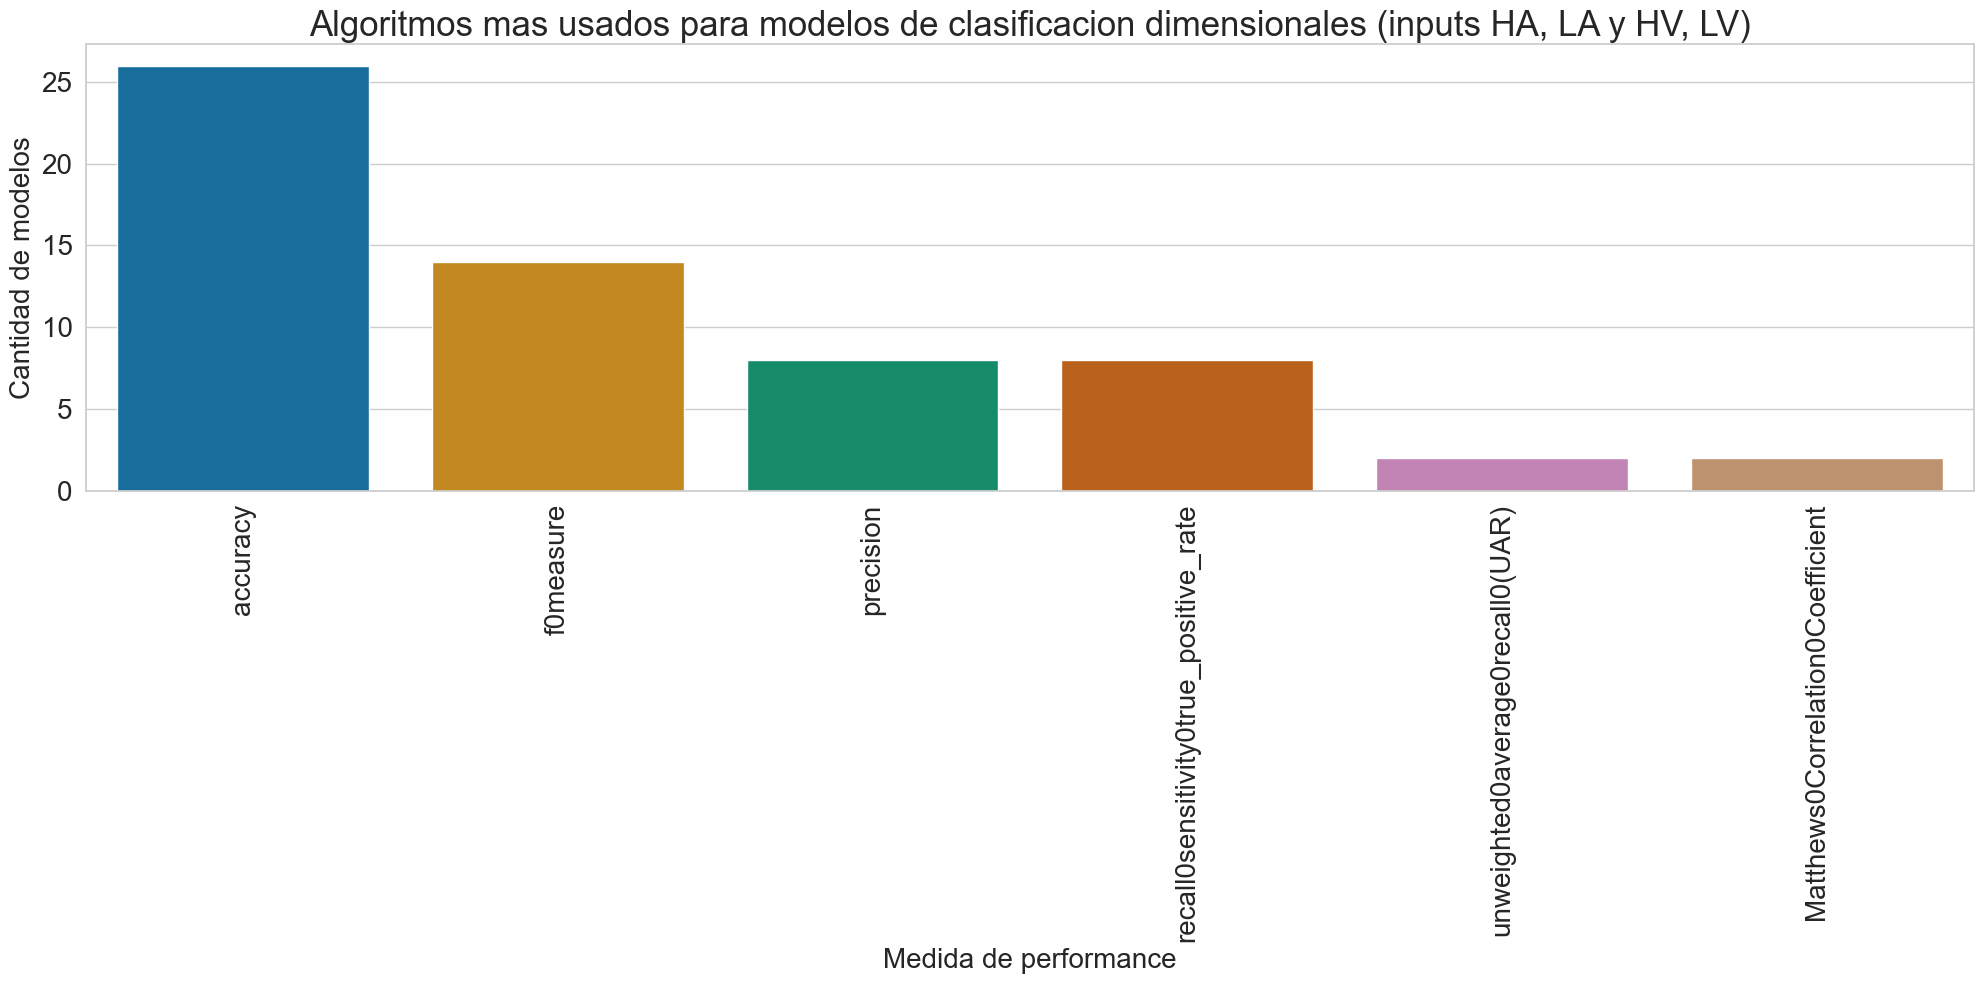

In [641]:
df_performance_medidas = multi_reversing_n(df2, 'paper_id',df2.iloc[:,5:])
titulos = ['Algoritmos mas usados para modelos de clasificacion dimensionales (inputs HA, LA y HV, LV)', 'Medida de performance', 'Cantidad de modelos']
bar_plot('variable',df_performance_medidas,titulos)

In [642]:
#filtramos por accuracy
df2 = df2.fillna('-')
df2 = df2[(df2['accuracy'] != '-') & (df2['accuracy'] != 0)]

In [643]:
df2[["paper_id", "apa_citation", "class_model_output_categories", "accuracy"]]

paper_id                                       apa_citation  \
0          3  Ayata, D., Yaslan, Y., & Kamasak, M. E. (2018)...   
1          3  Ayata, D., Yaslan, Y., & Kamasak, M. E. (2018)...   
4         20  Wiem, M. B. H., & Lachiri, Z. (2017). Emotion ...   
5         20  Wiem, M. B. H., & Lachiri, Z. (2017). Emotion ...   
6         23  Ayata, D., Yaslan, Y., & Kamasak, M. (2017). E...   
7         23  Ayata, D., Yaslan, Y., & Kamasak, M. (2017). E...   
10        32  Siddharth,  null, Jung, T.-P., & Sejnowski, T....   
11        32  Siddharth,  null, Jung, T.-P., & Sejnowski, T....   
12        38  Ayata, D., Yaslan, Y., & Kamasak, M. (2017). E...   
13        38  Ayata, D., Yaslan, Y., & Kamasak, M. (2017). E...   
14        64  Sharma, V., Prakash, N. R., & Kalra, P. (2019)...   
15        64  Sharma, V., Prakash, N. R., & Kalra, P. (2019)...   
16        67  Ganapathy, N., Veeranki, Y. R., & Swaminathan,...   
17        67  Ganapathy, N., Veeranki, Y. R., & Swaminathan,...   
20        75  Chang, E. J., Rahimi, A., Benini, L., & Wu, A....   
21        75  Chang, E. J., Rahimi, A., Benini, L., & Wu, A....   
24        83  Santamaria-Granados, L., Munoz-Organero, M., R...   
25        83  Santamaria-Granados, L., Munoz-Organero, M., R...   
26        87  Ganapathy, N., & Swaminathan, R. (2020). Emoti...   
27        87  Ganapathy, N., & Swaminathan, R. (2020). Emoti...   
28        92  Susanto, I. Y., Pan, T. Y., Chen, C. W., Hu, M...   
29        92  Susanto, I. Y., Pan, T. Y., Chen, C. W., Hu, M...   
30        95  Yin, G., Sun, S., Zhang, H., Yu, D., Li, C., Z...   
31        95  Yin, G., Sun, S., Zhang, H., Yu, D., Li, C., Z...   
34        98  Ganapathy, N., & Swaminathan, R. (2019). Emoti...   
35        98  Ganapathy, N., & Swaminathan, R. (2019). Emoti...   

   class_model_output_categories  accuracy  
0                         HA, LA     71.53  
1                         HV, LV     71.04  
4                         HA, LA     62.23  
5                         HV, LV     55.78  
6                         HA, LA     71.53  
7                         HV, LV     71.04  
10                        HA, LA     64.84  
11                        HV, LV     63.28  
12                        HA, LA     50.54  
13                        HV, LV     65.33  
14                        HA, LA     79.00  
15                        HV, LV     69.80  
16                        HV, LV     53.68  
17                        HA, LA     62.11  
20                        HV, LV     71.20  
21                        HA, LA     64.33  
24                        HA, LA     69.00  
25                        HV, LV     67.00  
26                        HA, LA     72.08  
27                        HV, LV     68.90  
28                        HA, LA     59.88  
29                        HV, LV     60.13  
30                        HV, LV     55.92  
31                        HA, LA     57.24  
34                        HA, LA     65.63  
35                        HV, LV     68.75

In [644]:
#creamos df para el analisis estadistico
df_3 = df2[["class_model_output_categories","accuracy"]]
df_3

class_model_output_categories  accuracy
0                         HA, LA     71.53
1                         HV, LV     71.04
4                         HA, LA     62.23
5                         HV, LV     55.78
6                         HA, LA     71.53
7                         HV, LV     71.04
10                        HA, LA     64.84
11                        HV, LV     63.28
12                        HA, LA     50.54
13                        HV, LV     65.33
14                        HA, LA     79.00
15                        HV, LV     69.80
16                        HV, LV     53.68
17                        HA, LA     62.11
20                        HV, LV     71.20
21                        HA, LA     64.33
24                        HA, LA     69.00
25                        HV, LV     67.00
26                        HA, LA     72.08
27                        HV, LV     68.90
28                        HA, LA     59.88
29                        HV, LV     60.13
30                        HV, LV     55.92
31                        HA, LA     57.24
34                        HA, LA     65.63
35                        HV, LV     68.75

Aplicamos los estadísticos

obtenido de: https://machinelearningmastery.com/statistical-hypothesis-tests-in-python-cheat-sheet/

In [645]:
#creacion lista con la performance para arousal y valence
df_arousal = df_3[df_3['class_model_output_categories'] == 'HA, LA']
df_arousal = df_arousal['accuracy']
arousal1 = df_arousal.values.tolist()
arousal1 = list(map(float, arousal1))

df_valence = df_3[df_3['class_model_output_categories'] == 'HV, LV']
df_valence = df_valence['accuracy']
valence1 = df_valence.values.tolist()
valence1 = list(map(float, valence1))

p1 = stats.ttest_rel(arousal1, valence1, alternative = "greater")

print(p1)

#Test parametrico - t de student
#t_student(arousal1, valence1)

#Test no parametrico - U de Mann-Whitney
#mann_whitney_u(arousal1, valence1)

Ttest_relResult(statistic=0.35229084656919984, pvalue=0.3653649152631109)


### ¿Cual es la performance promedio (usando accuracy) para cada anio?

1. Hacer un plots para ver como cambia la performance promedio (accuracy) en general con el paso del tiempo.  Esto lo resolveria con un box plot por año de accuracy. Donde en el eje X este de 2010 a 2020, y en el eje Y este el accuracy. Con este plot podriamos analizar si efectivamente mejora la performance de los modelos predictivos con el paso del tiempo

creacion df para el plot, con el anio las dimensiones y a performance

In [646]:
performances_av = df2[["year", "class_model_output_categories", "accuracy"]]
#reemplazos
performances_av[['class_model_output_categories']] = performances_av[['class_model_output_categories']].replace(['HA, LA', 'HV, LV' ], ['arousal', 'valence' ])
performances_av.rename(columns = {'class_model_output_categories':'dimension', 'accuracy':'performance'}, inplace = True)

performances_av

C:\Users\someo\AppData\Local\Temp\ipykernel_33180\1501514481.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  performances_av[['class_model_output_categories']] = performances_av[['class_model_output_categories']].replace(['HA, LA', 'HV, LV' ], ['arousal', 'valence' ])
C:\Users\someo\AppData\Local\Temp\ipykernel_33180\1501514481.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  performances_av.rename(columns = {'class_model_output_categories':'dimension', 'accuracy':'performance'}, inplace = True)


year dimension  performance
0   2018   arousal        71.53
1   2018   valence        71.04
4   2017   arousal        62.23
5   2017   valence        55.78
6   2017   arousal        71.53
7   2017   valence        71.04
10  2018   arousal        64.84
11  2018   valence        63.28
12  2017   arousal        50.54
13  2017   valence        65.33
14  2019   arousal        79.00
15  2019   valence        69.80
16  2020   valence        53.68
17  2020   arousal        62.11
20  2019   valence        71.20
21  2019   arousal        64.33
24  2019   arousal        69.00
25  2019   valence        67.00
26  2020   arousal        72.08
27  2020   valence        68.90
28  2020   arousal        59.88
29  2020   valence        60.13
30  2020   valence        55.92
31  2020   arousal        57.24
34  2020   arousal        65.63
35  2020   valence        68.75

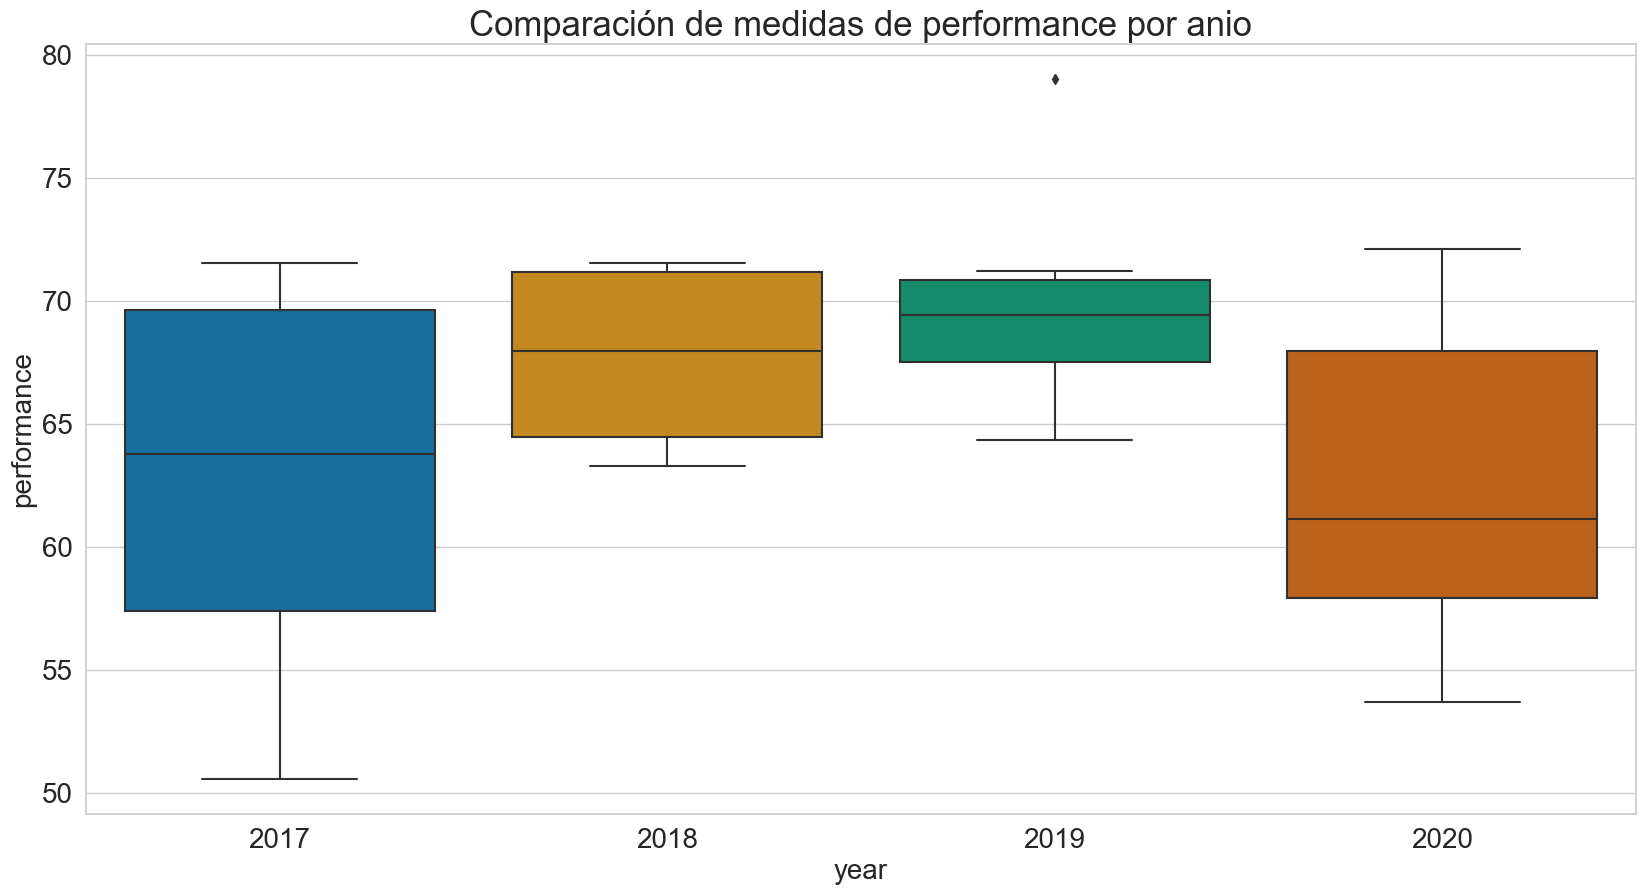

In [647]:
g = sns.boxplot(y="performance", x="year", data=performances_av)
g.set(title = 'Comparación de medidas de performance por anio')
plt.savefig('.\\Emmanuel\\figures\\NUEVOS. Comparación de medidas de performance por anio.png')

1.bis. subsjetear esta progresion de accuracies pero por dimension afectiva: hacer un plot (conjunto de boxplots de 2010 a 2020) de valencia y otro plot (conjunto de boxplots de 2010 a 2020) de arousal. Este plot nos ayudaría a ver si cambia la progresion de accuracies dependiendo cada dimension afectiva

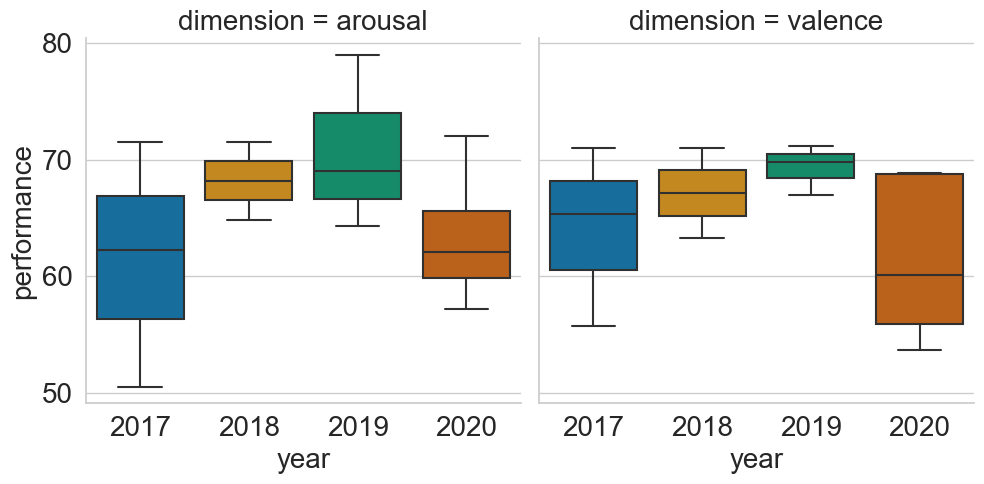

In [648]:
g = sns.catplot(x="year", y="performance", col =  "dimension", data=performances_av, kind="box")
plt.savefig('.\\Emmanuel\\figures\\NUEVOS. Comparación de medidas de performance por anio, para valence y arousal.png')

### ¿Cual es la evolucion temporal (2010-2020) del uso de los modelos de regresion y categoriales empleados?
Cantidad de modelos de regresion o categorial por anio

2. Hacer un plot de la progresión de modelos de regresión vs clasificación de 2010 a 2020. Este plot deberia ser igual al plot que ve la progresion de modelos dimensioanles vs categoriales. La idea con este plot seria analizar sin la progresion de papers basados en modelos dimensioanels se acompaña con modelso estadísticos de regresion (que es lo que se esperaria dado el tipo de variable, pero asumimos que no sucede)

In [649]:
def label_model (row):
   if row['is_classifier'] == "x" :
      return 'classifier'
   if row['is_regressor'] == "x" :
      return 'regressor'
   return 'Other'

In [650]:
df_statistical_learning_models['model']  = df_statistical_learning_models.apply(lambda row: label_model(row), axis=1)

In [651]:
df_statistical_learning_models['model'].value_counts()

classifier    453
regressor      46
Name: model, dtype: int64

In [652]:
df_models = df_statistical_learning_models[["apa_citation",'model', "year", "model_id"]]

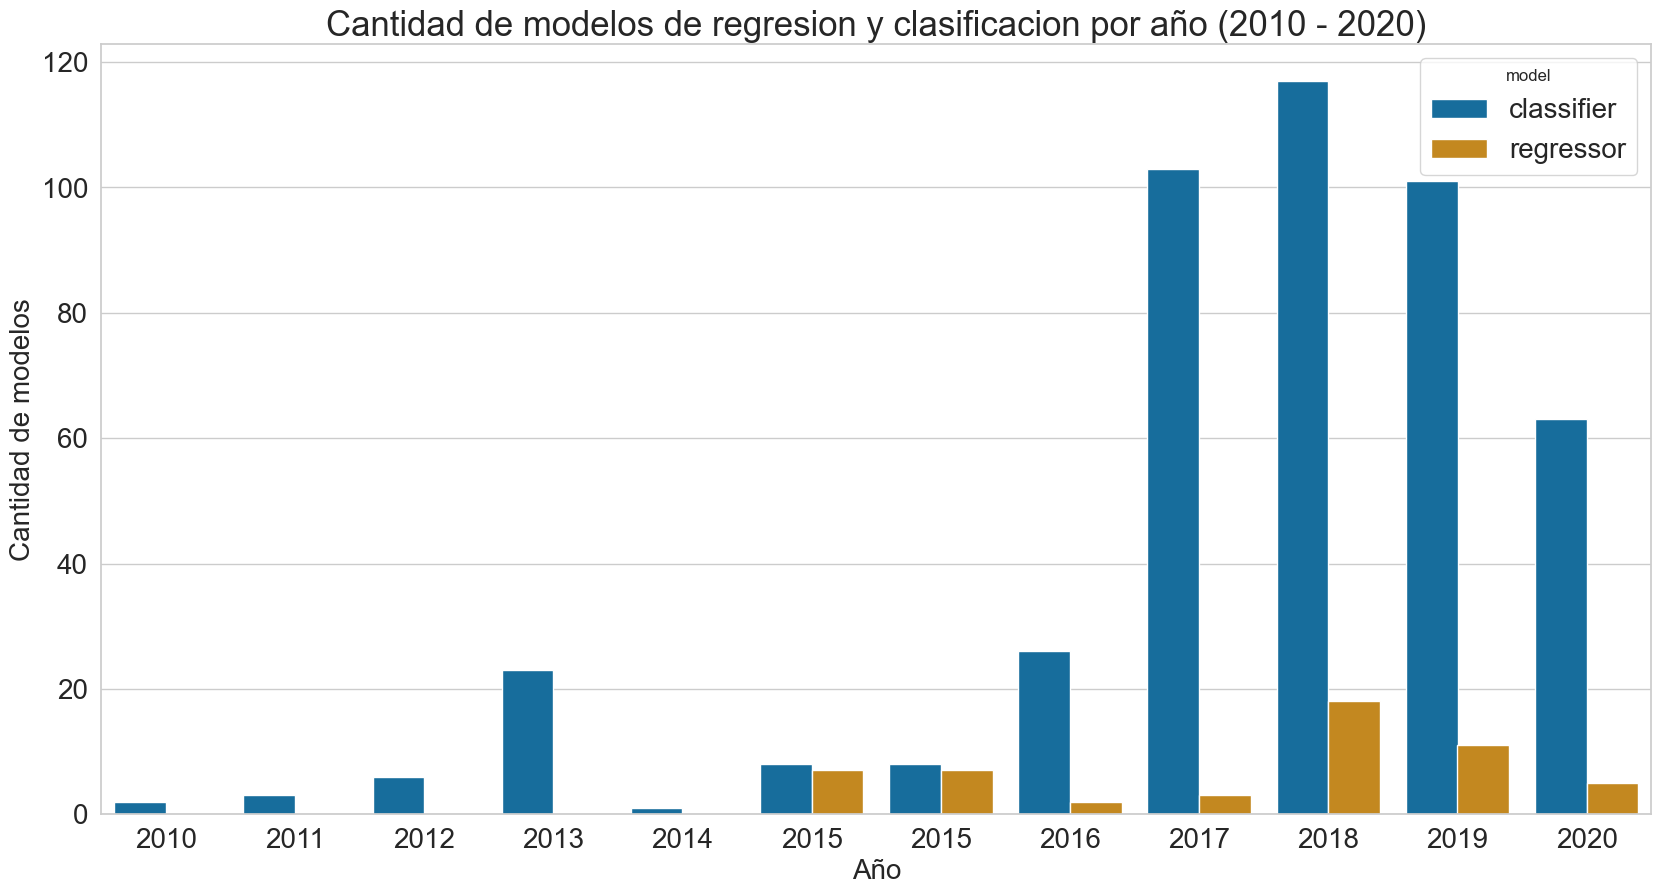

In [653]:
#ploteo
category_order = [2010, 2011, 2012, 2013, 2014, 2015, 2015, 2016, 2017, 2018, 2019, 2020]
g= sns.countplot(x='year', 
    data= df_models, 
    hue='model', 
    order=category_order)
g.set(title = 'Cantidad de modelos de regresion y clasificacion por año (2010 - 2020)', xlabel = 'Año', ylabel = 'Cantidad de modelos')
plt.savefig('.\\Emmanuel\\figures\\NUEVOS. Cantidad de modelos de regresion y clasificacion por año (2010 - 2020).png')

### ¿Cuantas veces fueron testeadas juntas las distintas dimensiones y categorias emocionales?

#### Primero obtenemos las categorias emocionales usadas y su frecuencia

* Hubo 55 modelos que usaron categorias emocionales, siendo disgust, fear, y sadness las mas repetidas.
* Tener en cuenta que un modelo puede usar mas de una categoria, por lo que la funcion get_values no funciona en este caso, y un paper puede concentrar la mayoria de los usos de un conjunto de categorias

Disgust       114
Fear          114
Sadness       114
Neutral        76
Surprise       75
Anxiety        72
Amusement      44
Joy            40
Happiness      37
Pleasant       33
Relaxation      8
Stress          5
Boredom         3
Funny           1
Name: variable, dtype: int64
['Stress' 'Disgust' 'Fear' 'Sadness' 'Surprise' 'Happiness' 'Pleasant'
 'Anxiety' 'Neutral' 'Funny' 'Boredom' 'Relaxation' 'Amusement' 'Joy']


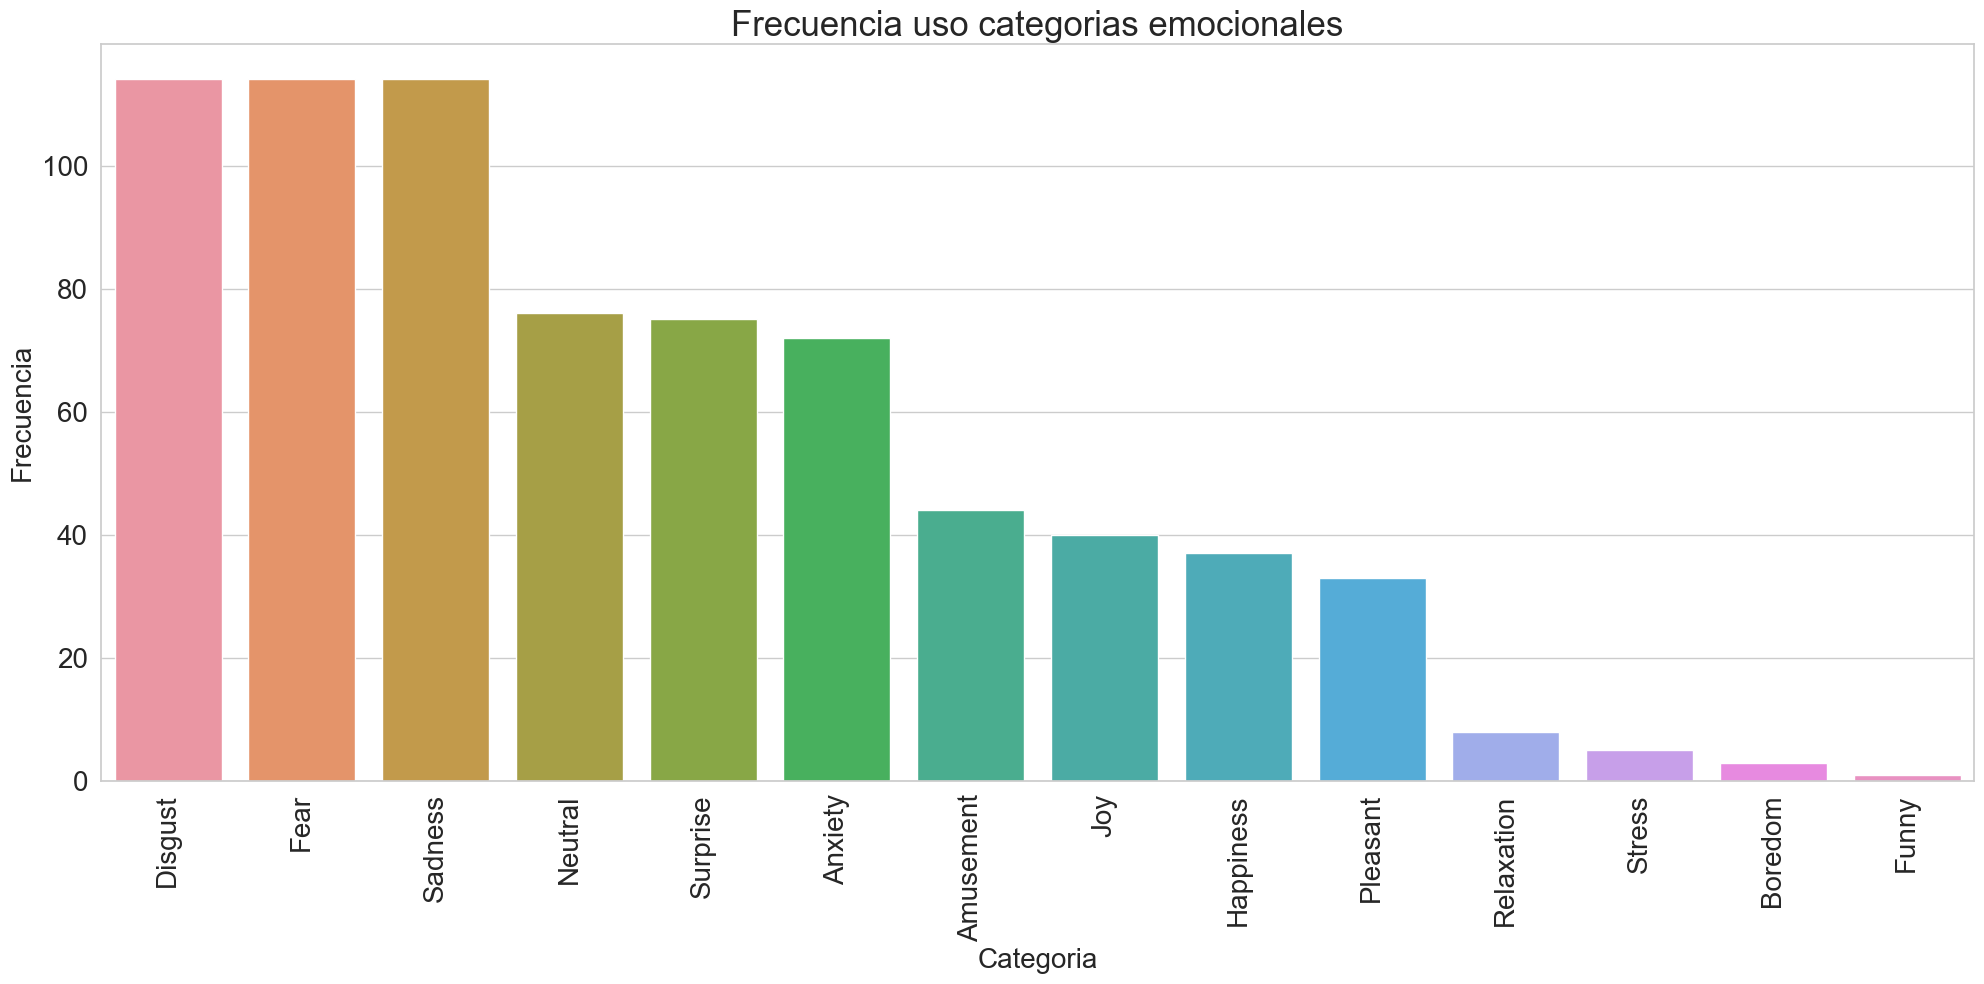

In [654]:
df_self_report=df_self_report.fillna('-')
#df_self_report = df_self_report.drop_duplicates(subset='paper_id')
df_self_report = df_self_report[df_self_report['is_categorial'].isin(['x', 'X'])]

emotional_categories = multi_reversing(df_self_report, 'model_id', df_self_report.iloc[:,19:])

print(emotional_categories['variable'].value_counts())
print(emotional_categories['variable'].unique())

titulos = ['Frecuencia uso categorias emocionales', 'Categoria', 'Frecuencia']
bar_plot('variable',emotional_categories,titulos)

#### Creamos el grafo
https://matplotlib.org/stable/tutorials/colors/colormaps.html

In [655]:
#creacion matrix de adyacencia
df_self_report.fillna('-', inplace= True)
self_0 = df_self_report[df_self_report['is_categorial']!= '-']

df_matrix_con_paperid_0 = self_0.groupby(
        ["paper_id",'Anger',
        'Stress', 'Disgust', 'Fear', 'Sadness', 'Surprise', 'Happiness',
        'Pleasant', 'Anxiety', 'Neutral', 'Funny', 'Boredom', 'Relaxation', 'Amusement', 'Joy']
        ).nth(0)
df_matrix_con_paperid_0.reset_index(inplace=True)

df_matrix = df_matrix_con_paperid_0[['Anger',
        'Stress', 'Disgust', 'Fear', 'Sadness', 'Surprise', 'Happiness',
        'Pleasant', 'Anxiety', 'Neutral', 'Funny', 'Boredom', 'Relaxation', 'Amusement', 'Joy']
        ]

df_matrix = df_matrix.replace('-', 0)
df_matrix = df_matrix.replace('x', 1)
adj_matrix = df_matrix.T.dot(df_matrix)
np.fill_diagonal(adj_matrix.values, 0)

In [656]:
adj_matrix

Anger  Stress  Disgust  Fear  Sadness  Surprise  Happiness  \
Anger           0       0       18    18       18        17          8   
Stress          0       0        0     0        0         0          0   
Disgust        18       0        0    19       19        17          8   
Fear           18       0       19     0       19        17          8   
Sadness        18       0       19    19        0        17          8   
Surprise       17       0       17    17       17         0          8   
Happiness       8       0        8     8        8         8          0   
Pleasant        0       0        1     1        1         0          0   
Anxiety         9       0       10    10       10         9          0   
Neutral        17       0       17    17       17        17          8   
Funny           0       0        0     0        0         0          0   
Boredom         0       0        0     0        0         0          0   
Relaxation      0       0        0     0        0         0          0   
Amusement      10       0       10    10       10         9          0   
Joy             9       0        9     9        9         9          0   

            Pleasant  Anxiety  Neutral  Funny  Boredom  Relaxation  Amusement  \
Anger              0        9       17      0        0           0         10   
Stress             0        0        0      0        0           0          0   
Disgust            1       10       17      0        0           0         10   
Fear               1       10       17      0        0           0         10   
Sadness            1       10       17      0        0           0         10   
Surprise           0        9       17      0        0           0          9   
Happiness          0        0        8      0        0           0          0   
Pleasant           0        1        0      0        0           0          0   
Anxiety            1        0        9      0        0           0          9   
Neutral            0        9        0      1        0           0          9   
Funny              0        0        1      0        0           0          0   
Boredom            0        0        0      0        0           0          0   
Relaxation         0        0        0      0        0           0          0   
Amusement          0        9        9      0        0           0          0   
Joy                0        9        9      0        0           0          9   

            Joy  
Anger         9  
Stress        0  
Disgust       9  
Fear          9  
Sadness       9  
Surprise      9  
Happiness     0  
Pleasant      0  
Anxiety       9  
Neutral       9  
Funny         0  
Boredom       0  
Relaxation    0  
Amusement     9  
Joy           0

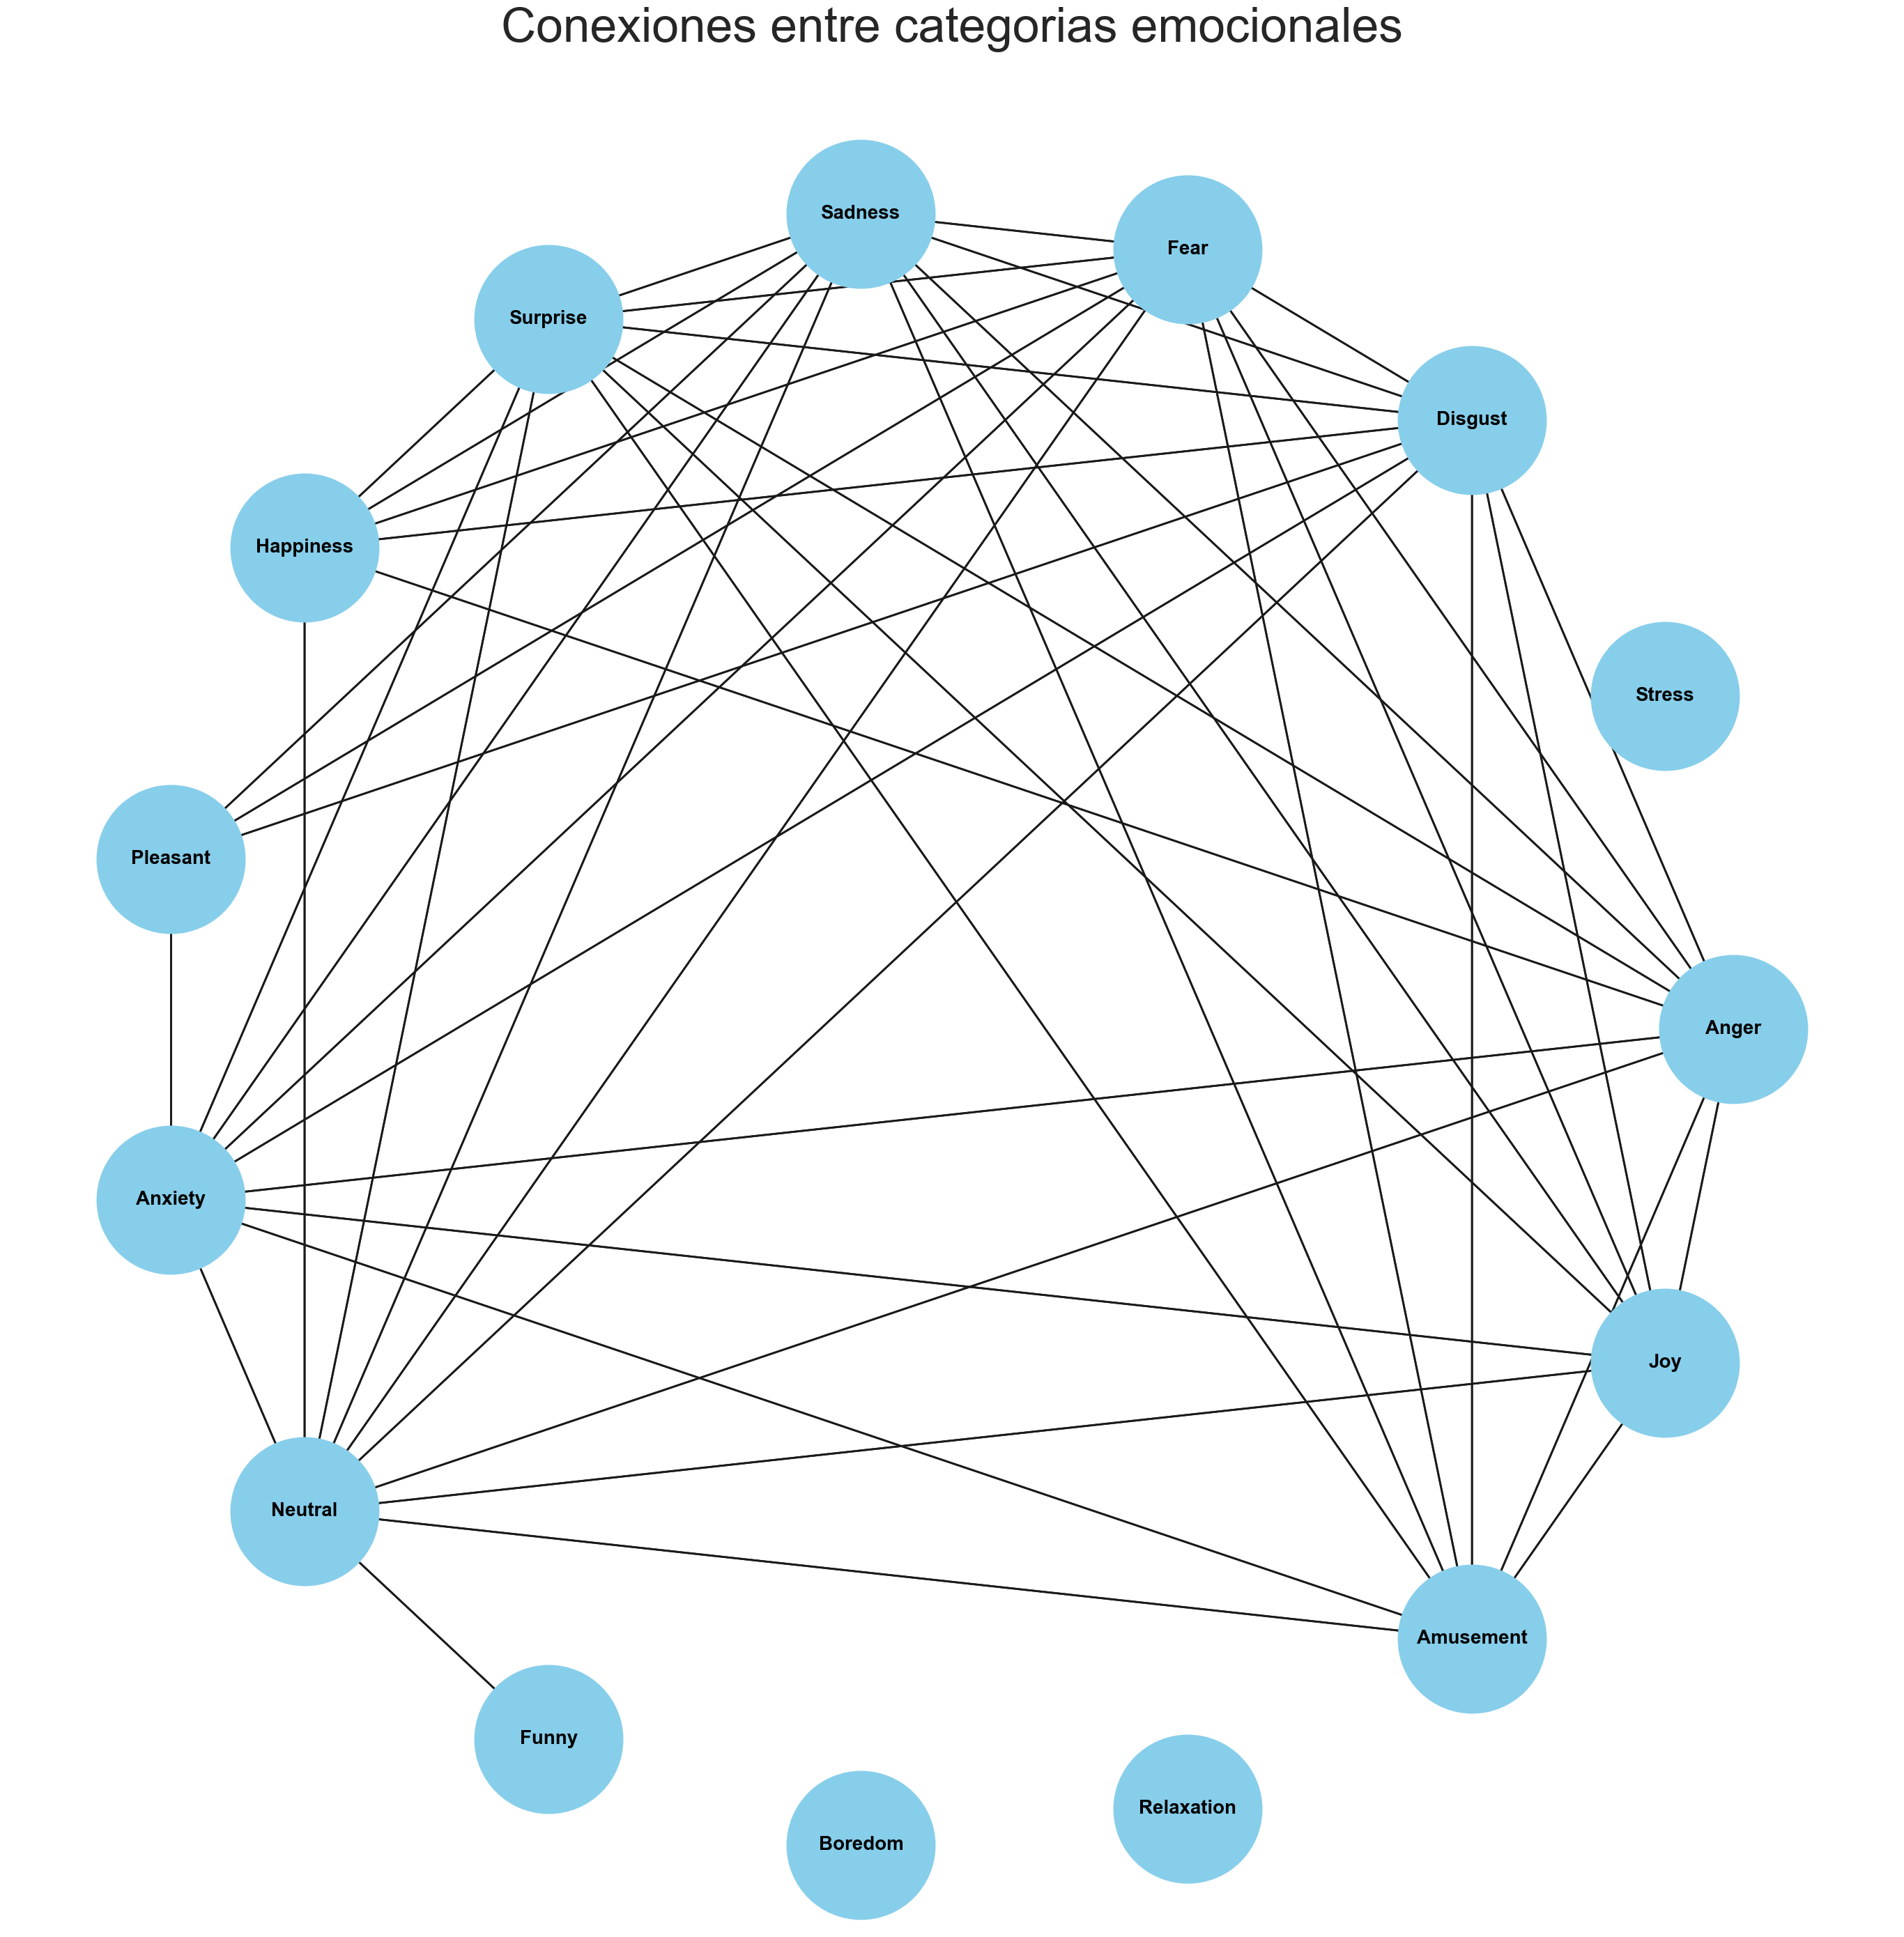

In [657]:
G = nx.DiGraph(adj_matrix)

fig, ax = plt.subplots(figsize=(35, 35))

plt.title('Conexiones entre categorias emocionales', fontdict = {'fontsize' : 50})

g = nx.draw_circular(G, 
        with_labels=True,
        node_size=13000,
        node_color="skyblue",
        linewidths=40,
        font_size=20,
        font_color="black",
        font_weight="bold",
        width=2)
plt.savefig('.\\Emmanuel\\figures\\NUEVOS. Conexiones entre categorias emocionales.png')

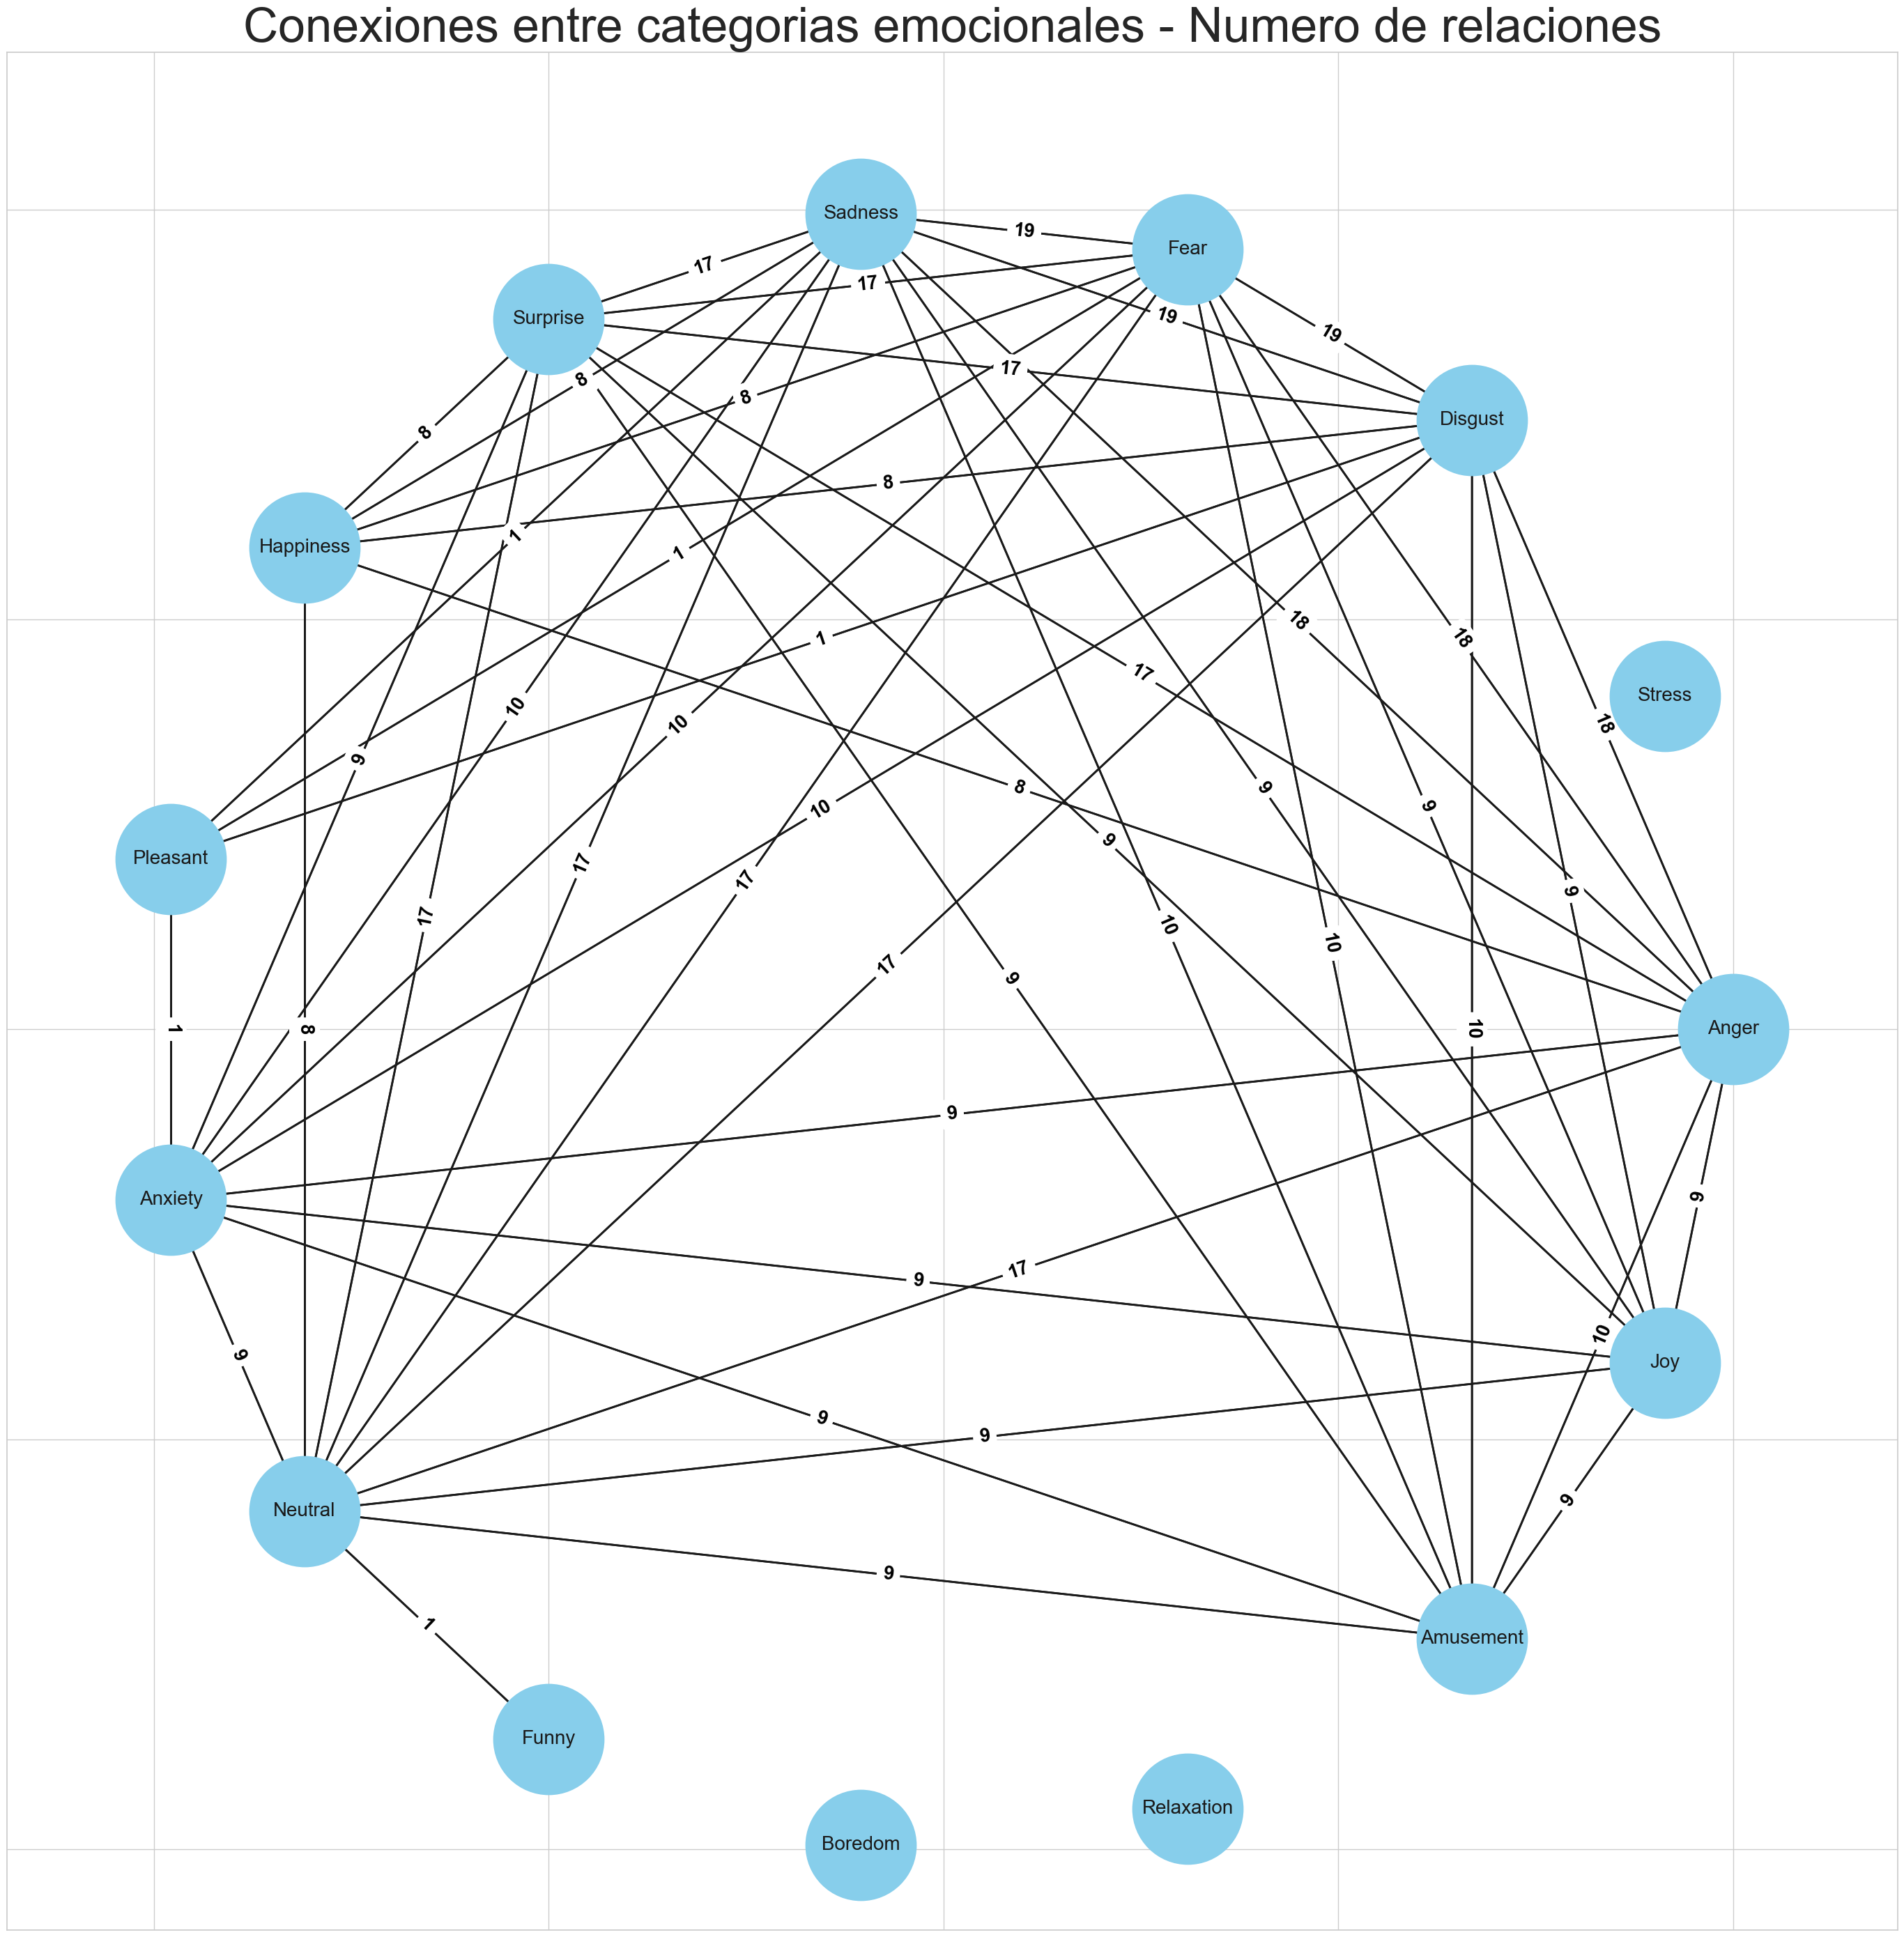

In [658]:
G.number_of_edges()

fig, ax = plt.subplots(figsize=(35, 35))

pos=nx.circular_layout(G)
weights=[wt for u, v, wt in G.edges(data="weight")]

plt.title('Conexiones entre categorias emocionales - Numero de relaciones', fontdict = {'fontsize' : 50})

nx.draw_networkx(G,pos,
        width=2,
        arrows=False,
        node_size=13000,
        node_color="skyblue",
        font_size=20)

labels=nx.get_edge_attributes(G, "weight") # entiendo que esto te permite poner la cantidad de frecuencia de cada relación con una etiqueta

nx.draw_networkx_edge_labels(G,pos,
        edge_labels=labels,
        font_size=20,
        font_color="black",
        font_weight="bold")

plt.savefig('.\\Emmanuel\\figures\\NUEVOS. Conexiones entre categorias emocionales - Numero de relaciones.png')

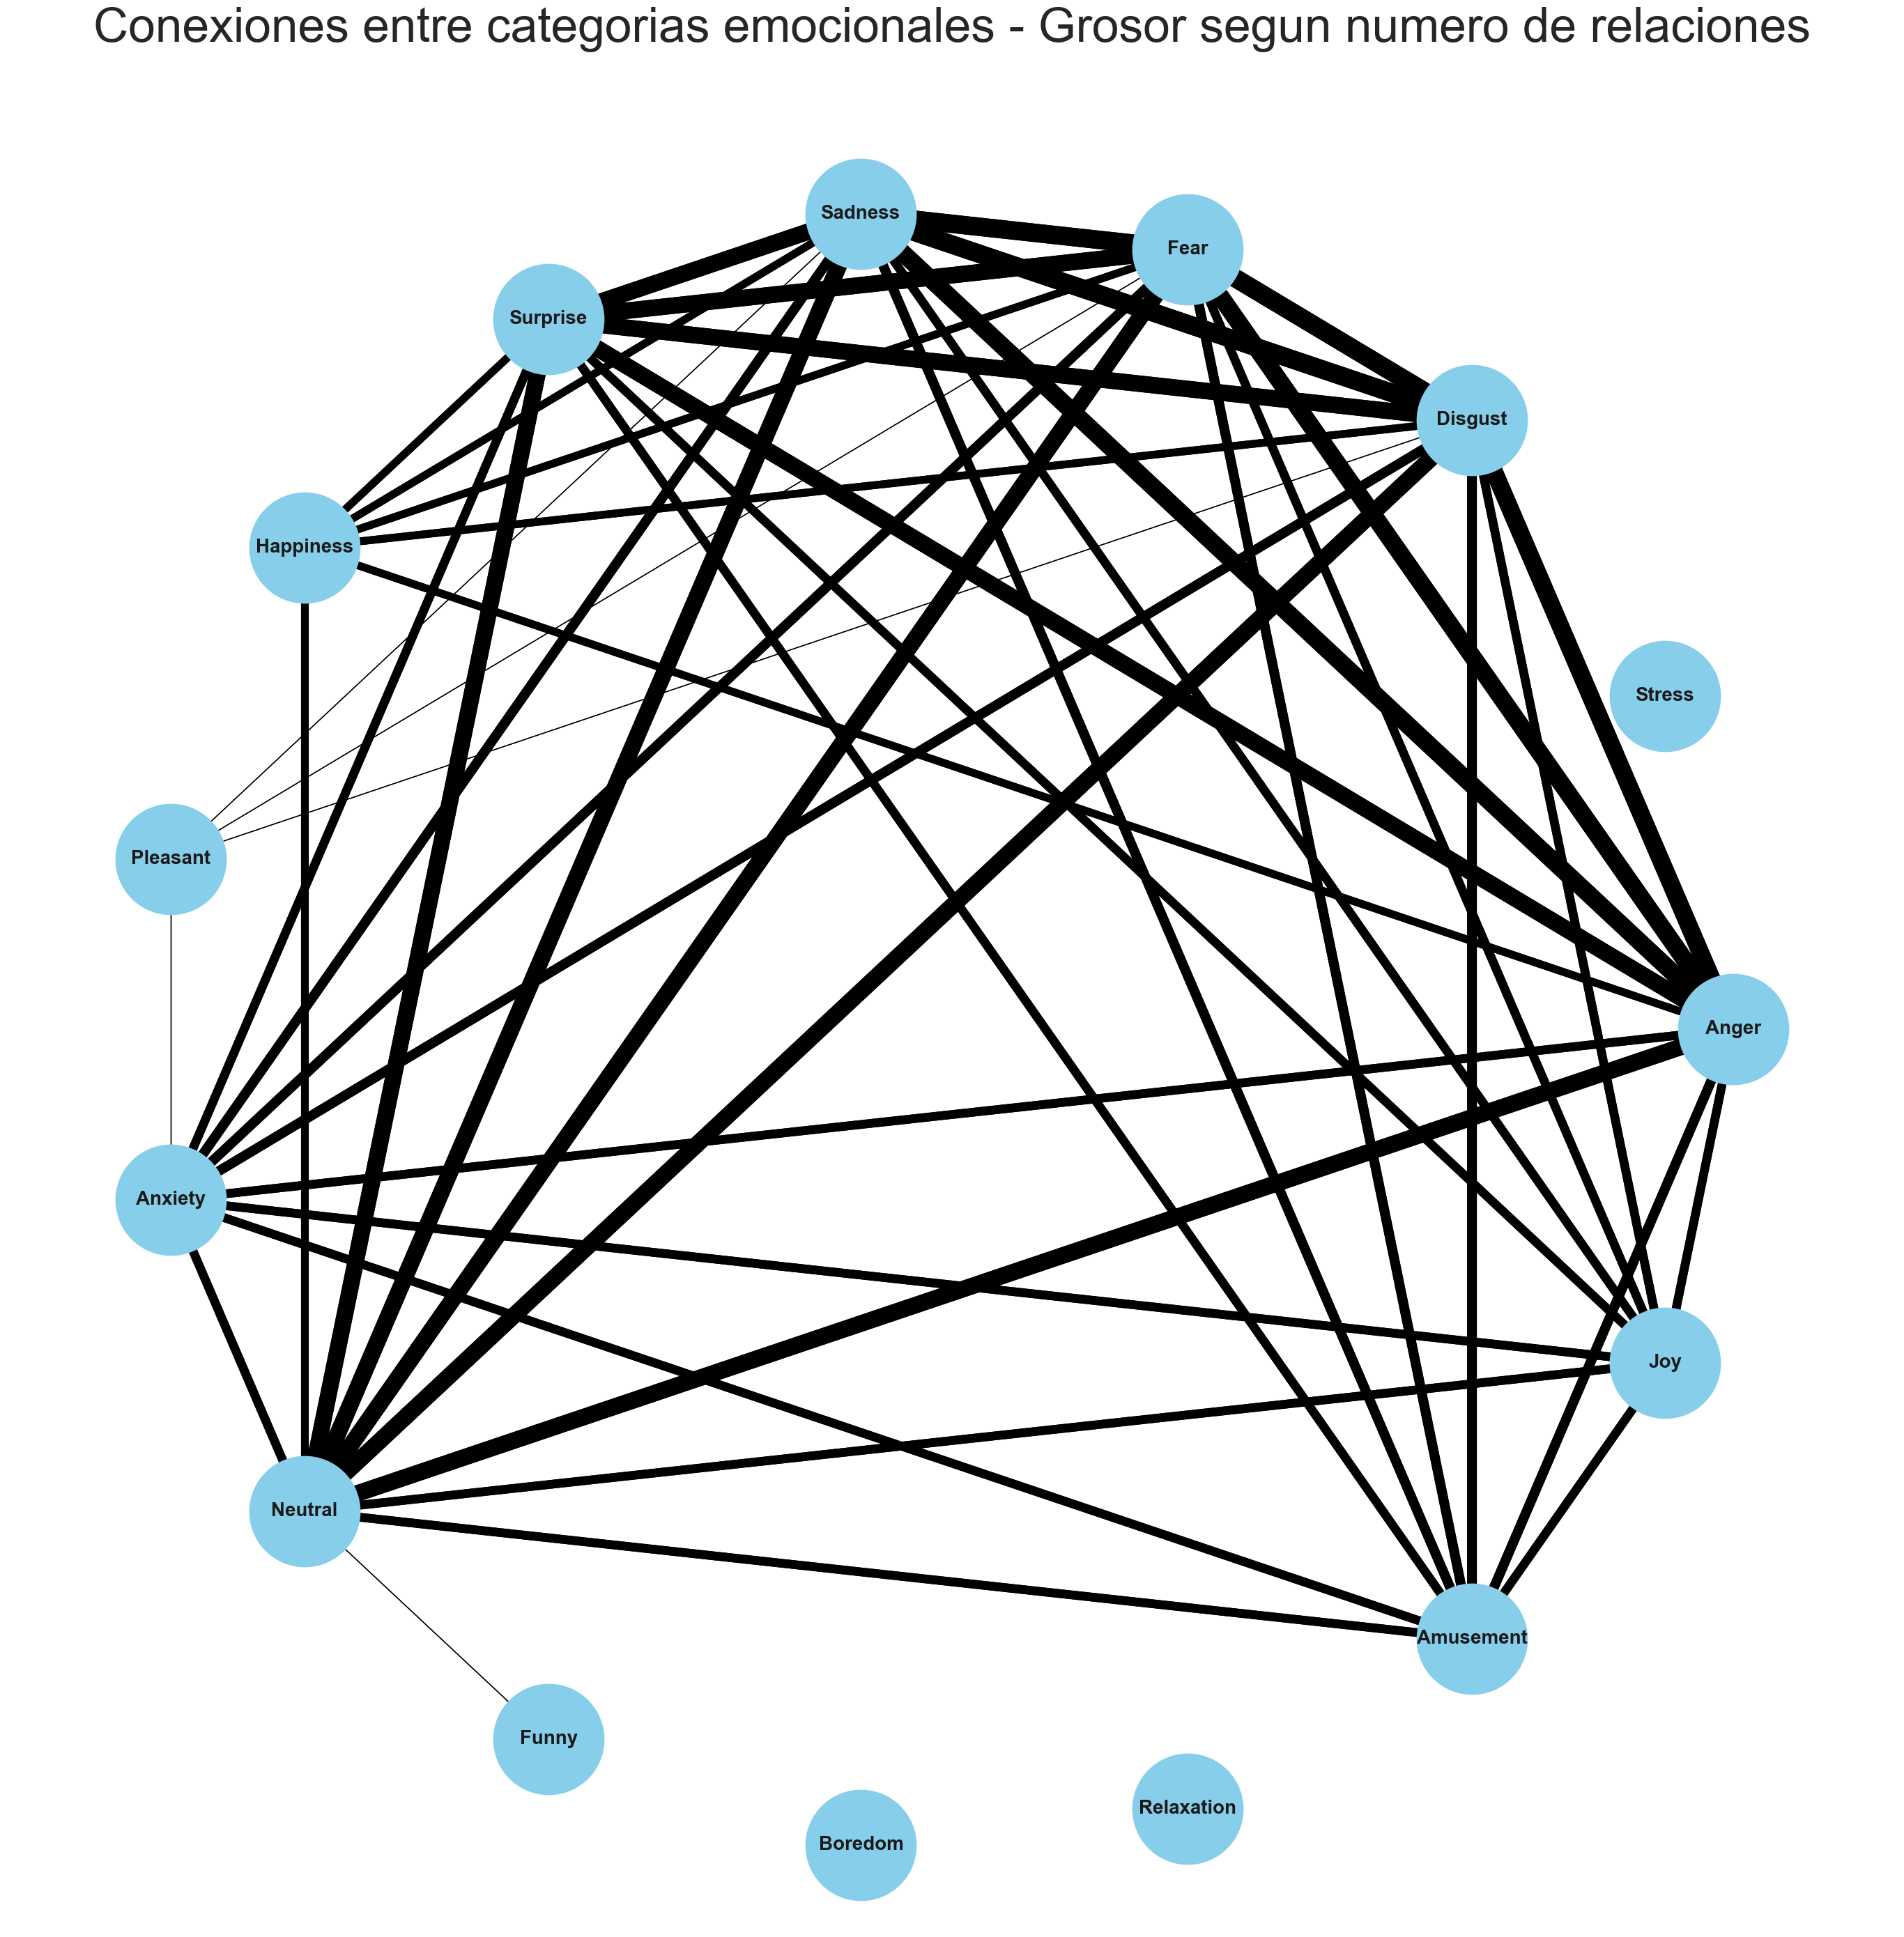

In [659]:
weights = nx.get_edge_attributes(G,'weight').values()

fig, ax = plt.subplots(figsize=(35, 35))

pos = nx.circular_layout(G)

plt.title('Conexiones entre categorias emocionales - Grosor segun numero de relaciones', fontdict = {'fontsize' : 50})

nx.draw(G, pos, 
        edge_color="black", 
        node_color='skyblue',
        width=[i for i in weights],
        with_labels=True,
        node_size=13000,
        alpha=1,
        font_size=20,
        font_weight="bold",
        arrows=False,
        edge_cmap=plt.colormaps['copper'])

plt.savefig('.\\Emmanuel\\figures\\NUEVOS. Conexiones entre categorias emocionales - Grosor segun numero de relaciones.png')

In [660]:
relaciones(weights)

Interacciones con 9 conexiones se observaron 14.0 veces.
Interacciones con 17 conexiones se observaron 9.0 veces.
Interacciones con 10 conexiones se observaron 7.0 veces.
Interacciones con 8 conexiones se observaron 6.0 veces.
Interacciones con 1 conexiones se observaron 5.0 veces.
Interacciones con 18 conexiones se observaron 3.0 veces.
Interacciones con 19 conexiones se observaron 3.0 veces.


Grafo para dimensiones emocionales (no categorias emocionales)

In [661]:
#creacion matrix de adyacencia
df_self_report.fillna('-', inplace= True)
self_dim = df_self_report[df_self_report['is_dimensional']!= '-']

df_matrix_con_paperid_dim = self_dim.groupby(
        ['paper_id','valence', 'arousal', 'dominance', 'like / dislike', 'familiarity', 'engagement', 'predictability']
        ).nth(0)
df_matrix_con_paperid_dim.reset_index(inplace=True)

df_matrix_dim = df_matrix_con_paperid_dim[
        ['valence', 'arousal', 'dominance', 'like / dislike', 'familiarity', 'engagement', 'predictability']
        ]

df_matrix_dim = df_matrix_dim.replace('-', 0)
df_matrix_dim = df_matrix_dim.replace('x', 1)
adj_matrix_dim = df_matrix_dim.T.dot(df_matrix_dim)
np.fill_diagonal(adj_matrix_dim.values, 0)

In [662]:
adj_matrix_dim

valence  arousal  dominance  like / dislike  familiarity  \
valence               0       19         18               8            8   
arousal              19        0         18               8            8   
dominance            18       18          0               8            8   
like / dislike        8        8          8               0            8   
familiarity           8        8          8               8            0   
engagement            0        0          0               0            0   
predictability        9        9          9               0            0   

                engagement  predictability  
valence                  0               9  
arousal                  0               9  
dominance                0               9  
like / dislike           0               0  
familiarity              0               0  
engagement               0               0  
predictability           0               0

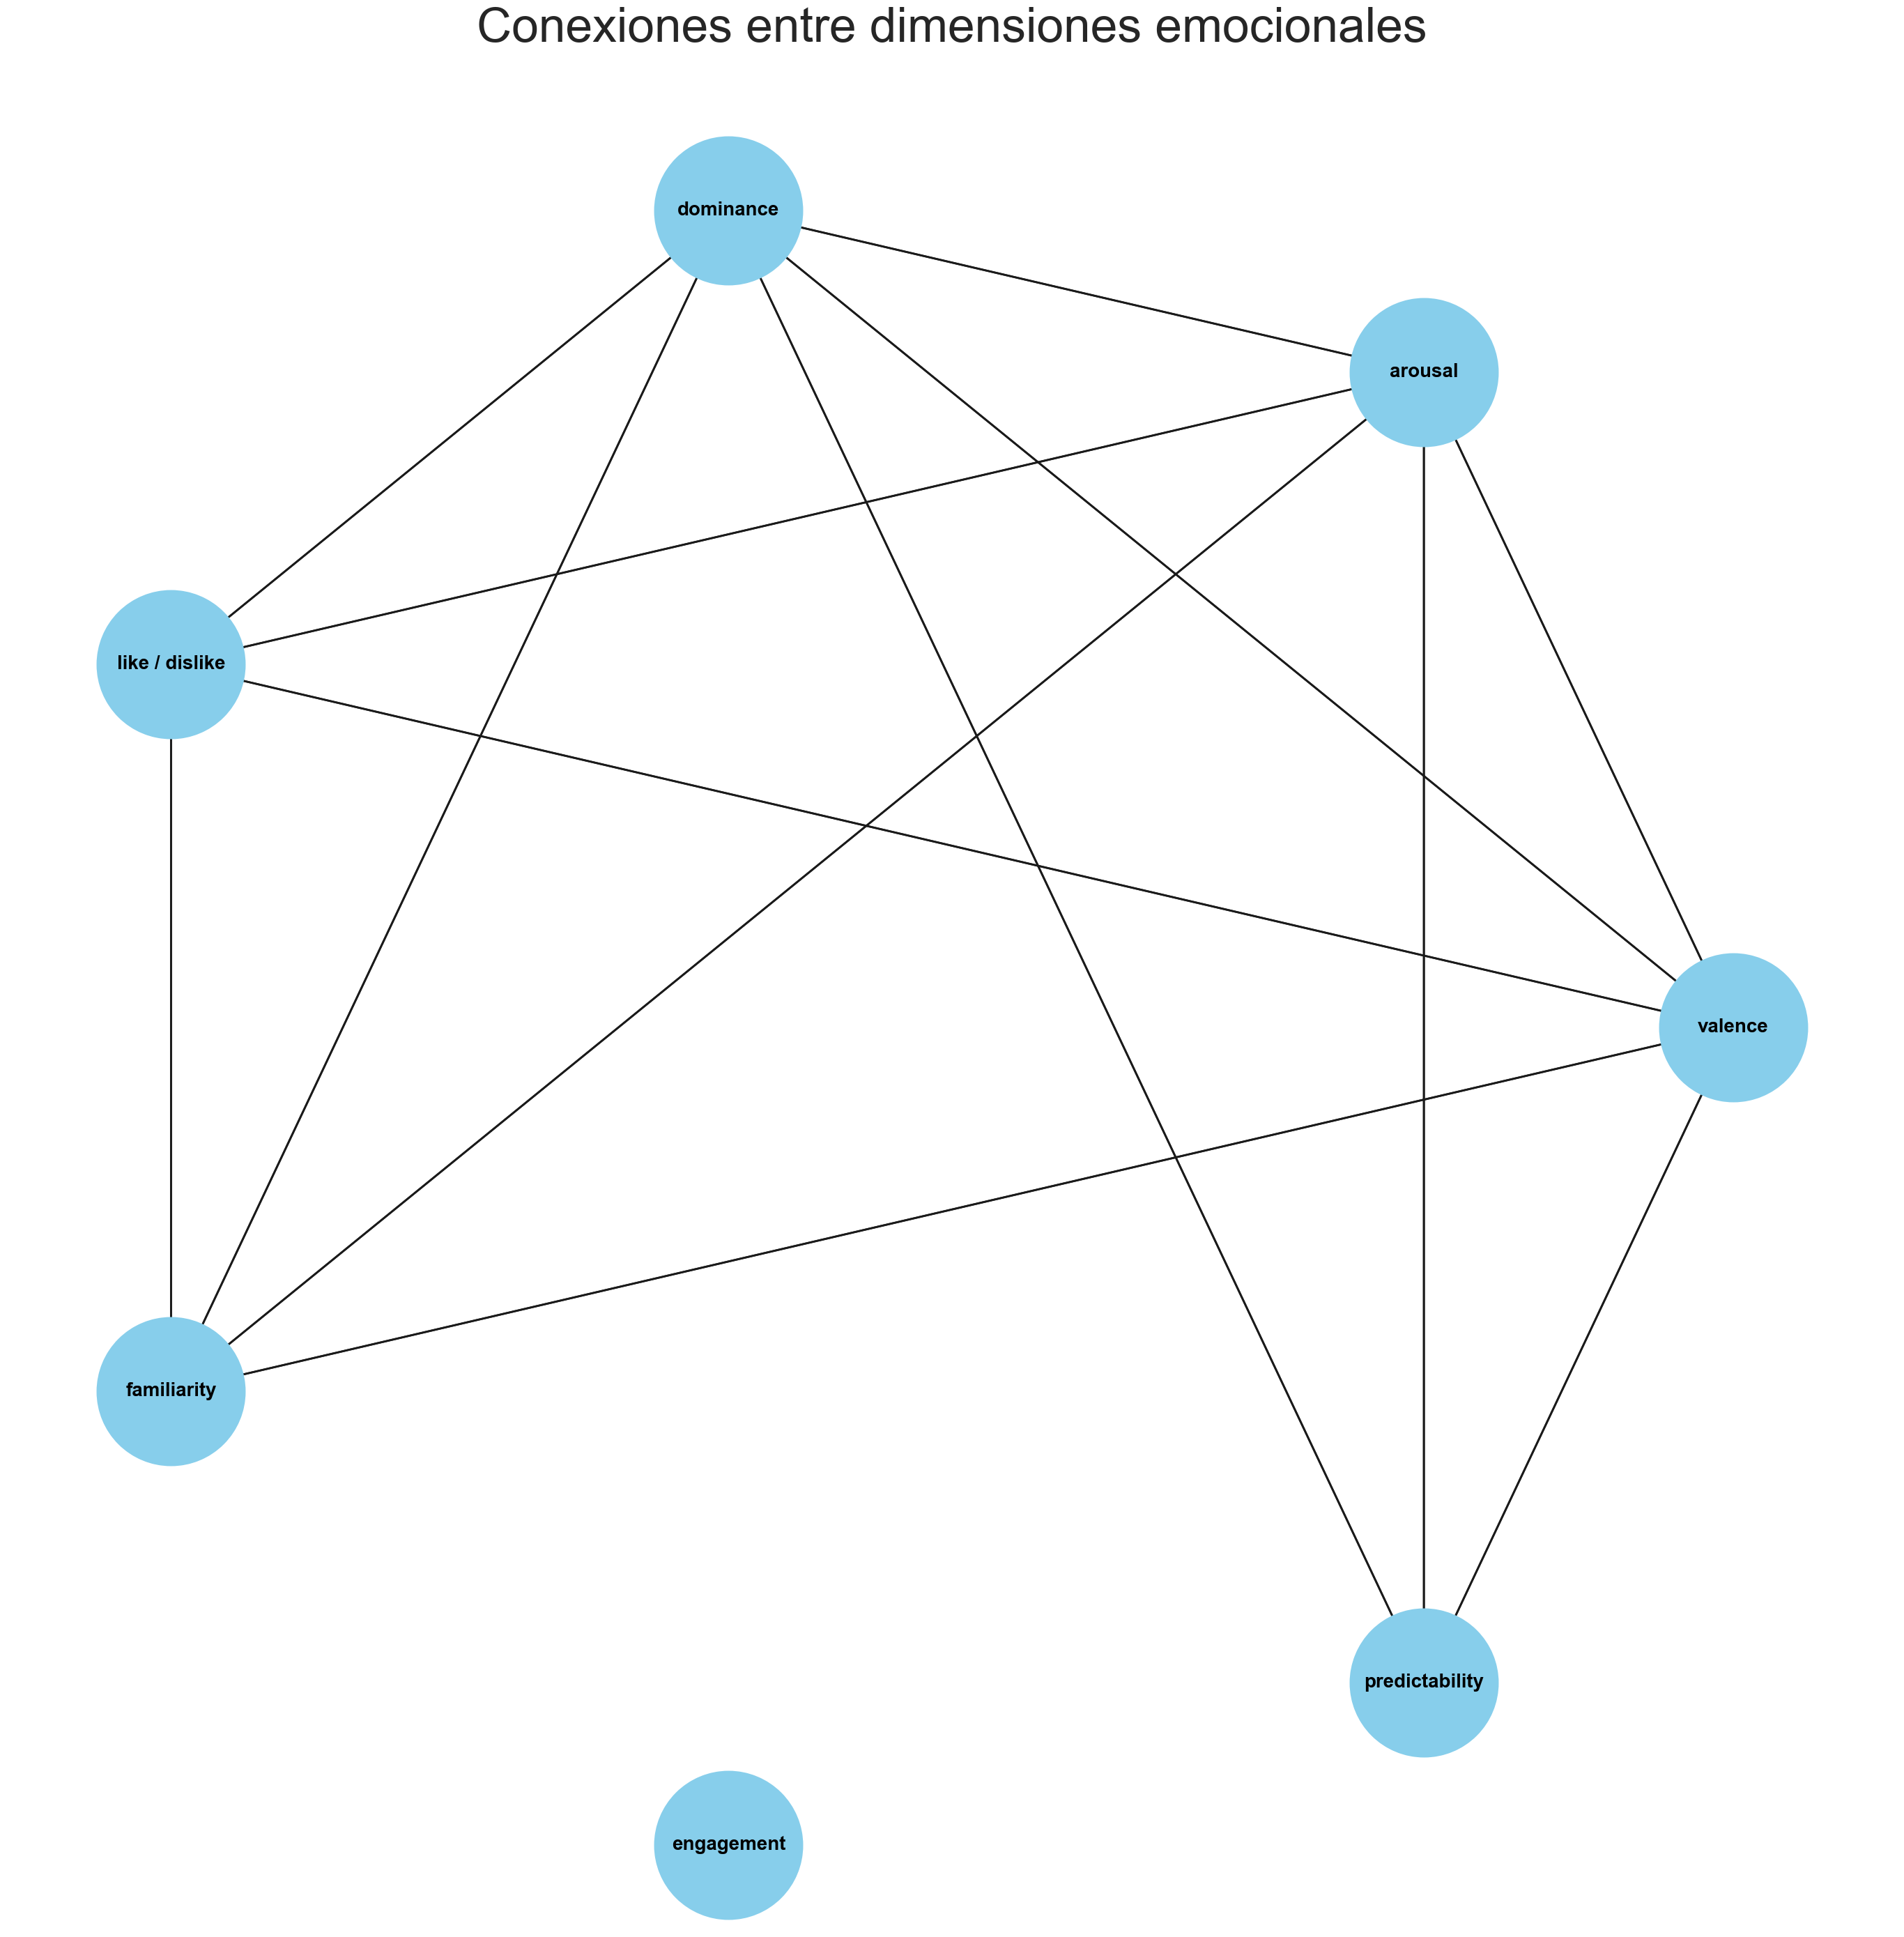

In [663]:
Gd = nx.DiGraph(adj_matrix_dim)

fig, ax = plt.subplots(figsize=(35, 35))

plt.title('Conexiones entre dimensiones emocionales', fontdict = {'fontsize' : 50})

nx.draw_circular(Gd, 
        with_labels=True,
        node_size=13000,
        node_color="skyblue",
        linewidths=40,
        font_size=20,
        font_color="black",
        font_weight="bold",
        width=2)

plt.savefig('.\\Emmanuel\\figures\\NUEVOS. Conexiones entre dimensiones emocionales.png')

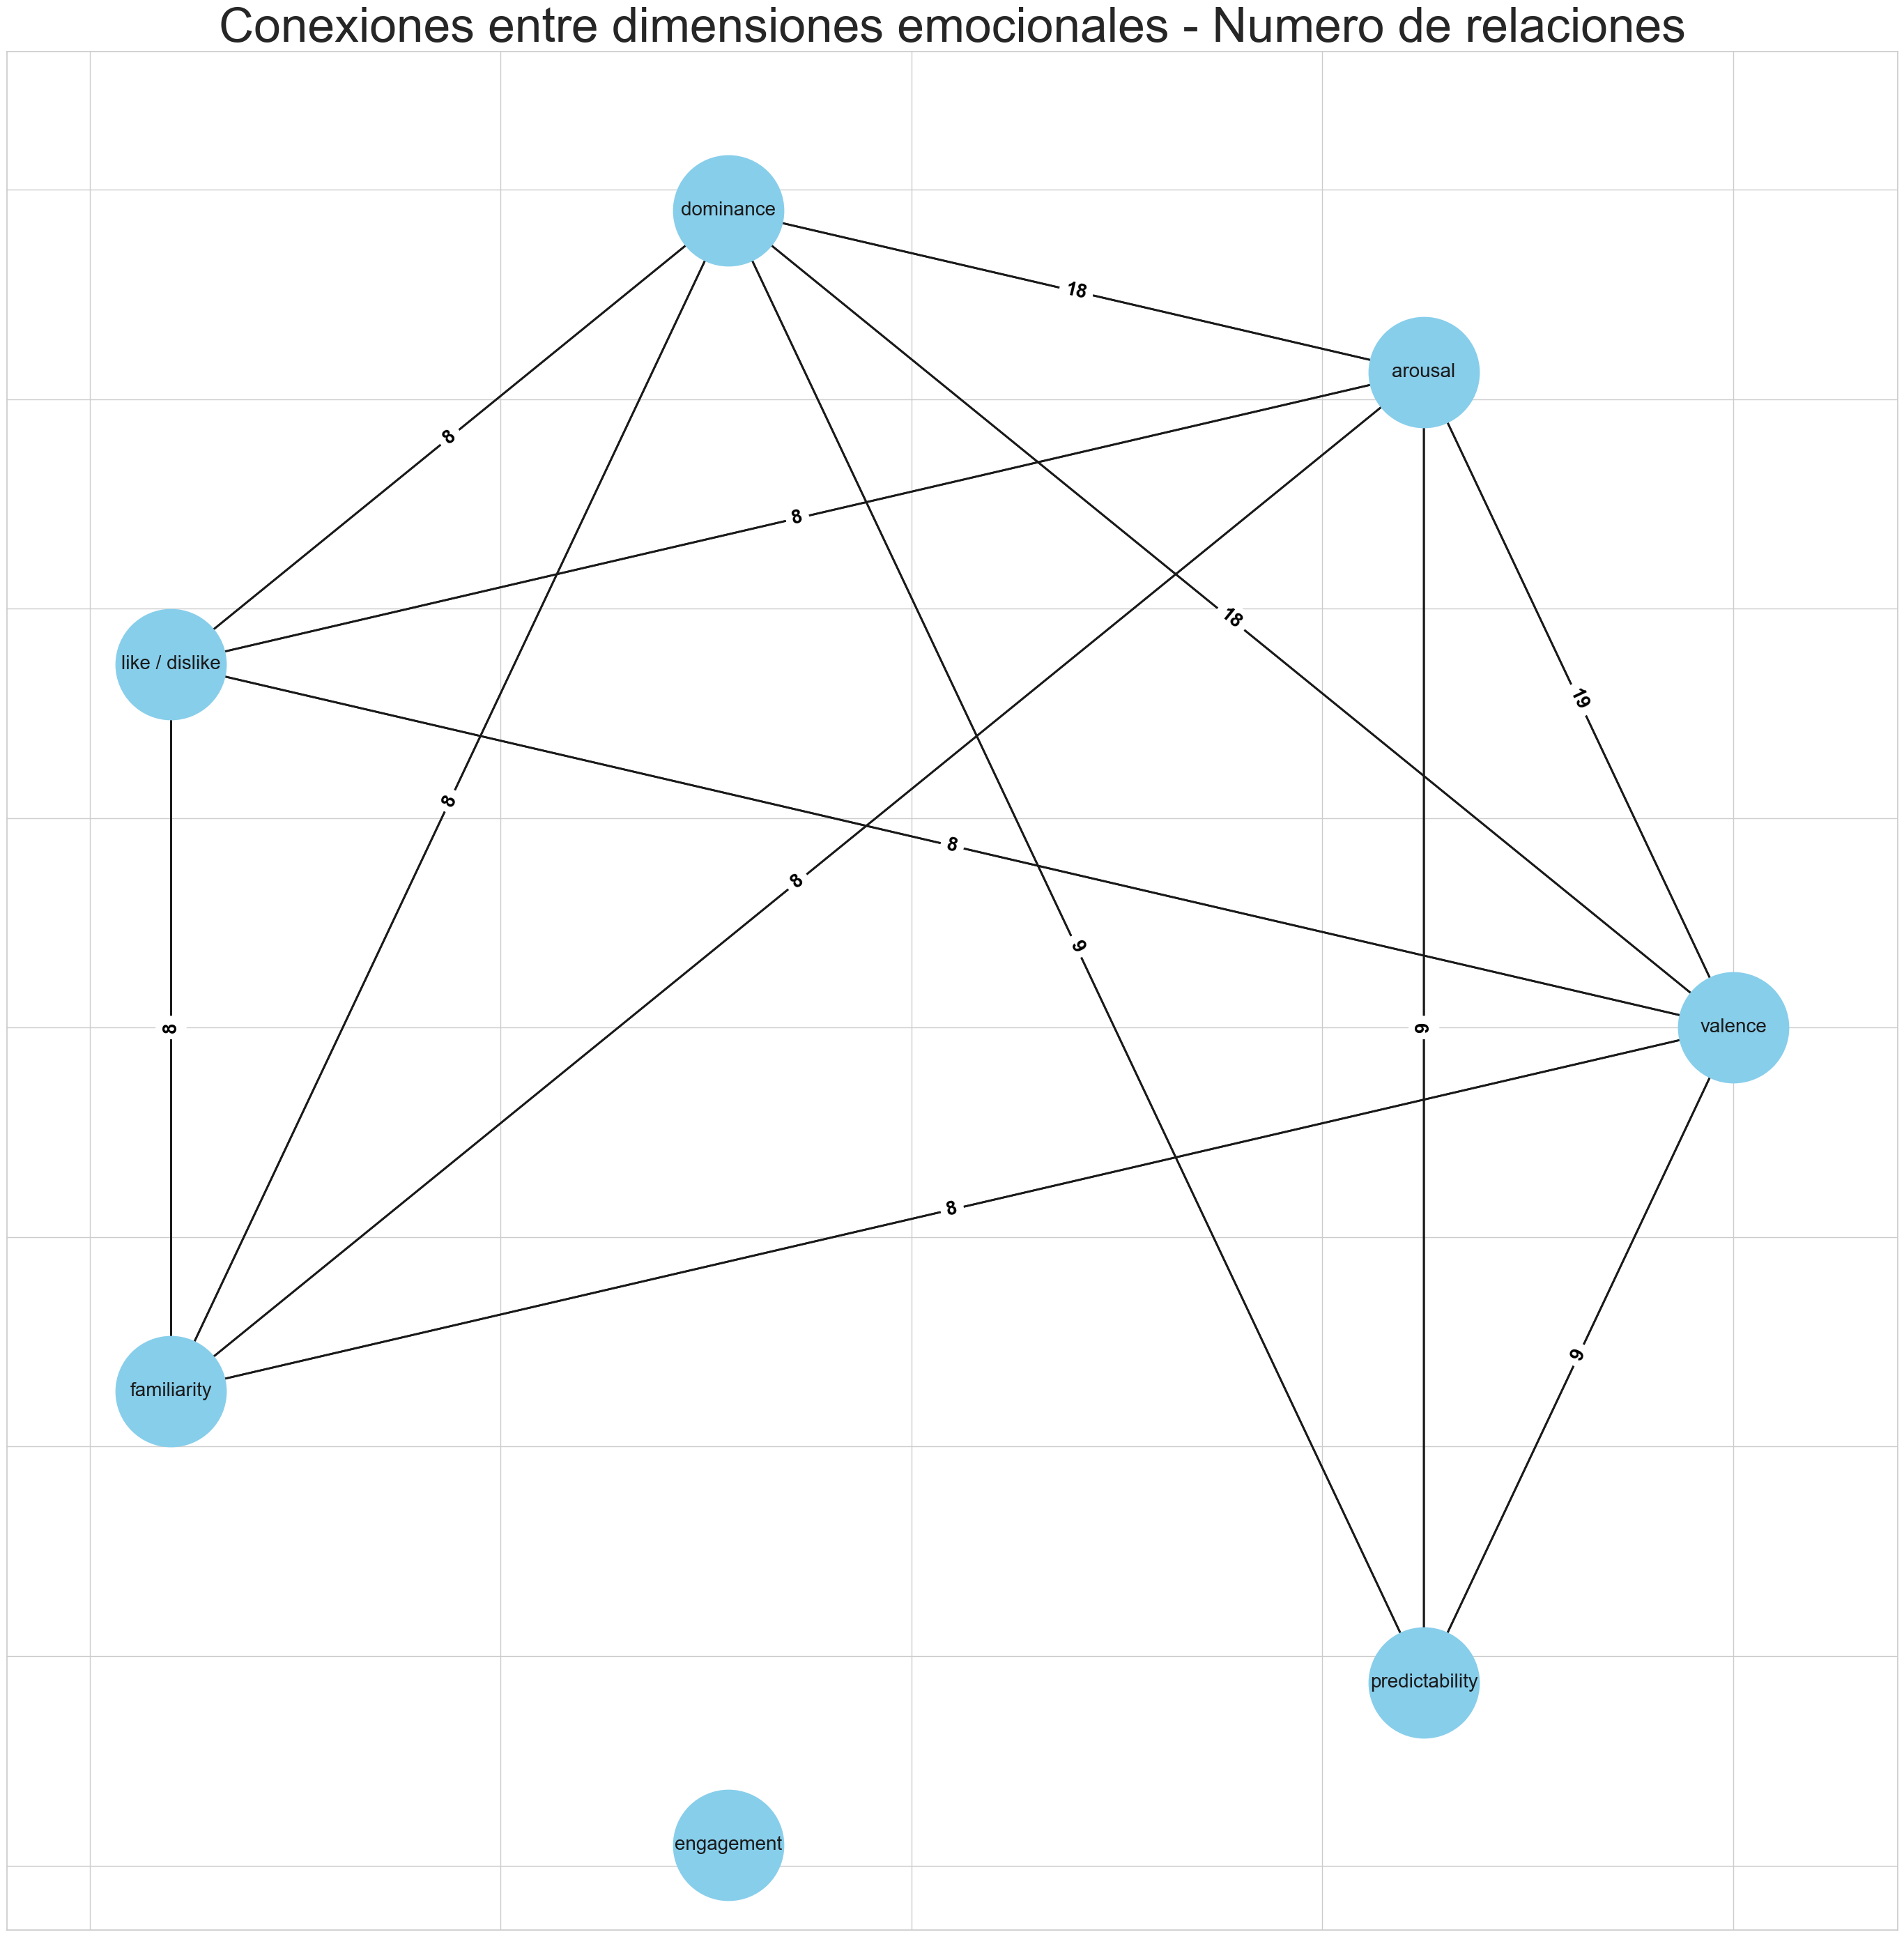

In [664]:
Gd.number_of_edges()

fig, ax = plt.subplots(figsize=(35, 35))

pos=nx.circular_layout(Gd)
weights=[wt for u, v, wt in Gd.edges(data="weight")]

plt.title('Conexiones entre dimensiones emocionales - Numero de relaciones', fontdict = {'fontsize' : 50})

nx.draw_networkx(Gd,pos,
        width=2,
        arrows=False,
        node_size=13000,
        node_color="skyblue",
        font_size=20)

labels=nx.get_edge_attributes(Gd, "weight") # entiendo que esto te permite poner la cantidad de frecuencia de cada relación con una etiqueta

nx.draw_networkx_edge_labels(Gd,pos,
        edge_labels=labels,
        font_size=20,
        font_color="black",
        font_weight="bold")

plt.savefig('.\\Emmanuel\\figures\\NUEVOS. Conexiones entre dimensiones emocionales - Numero de relaciones.png')

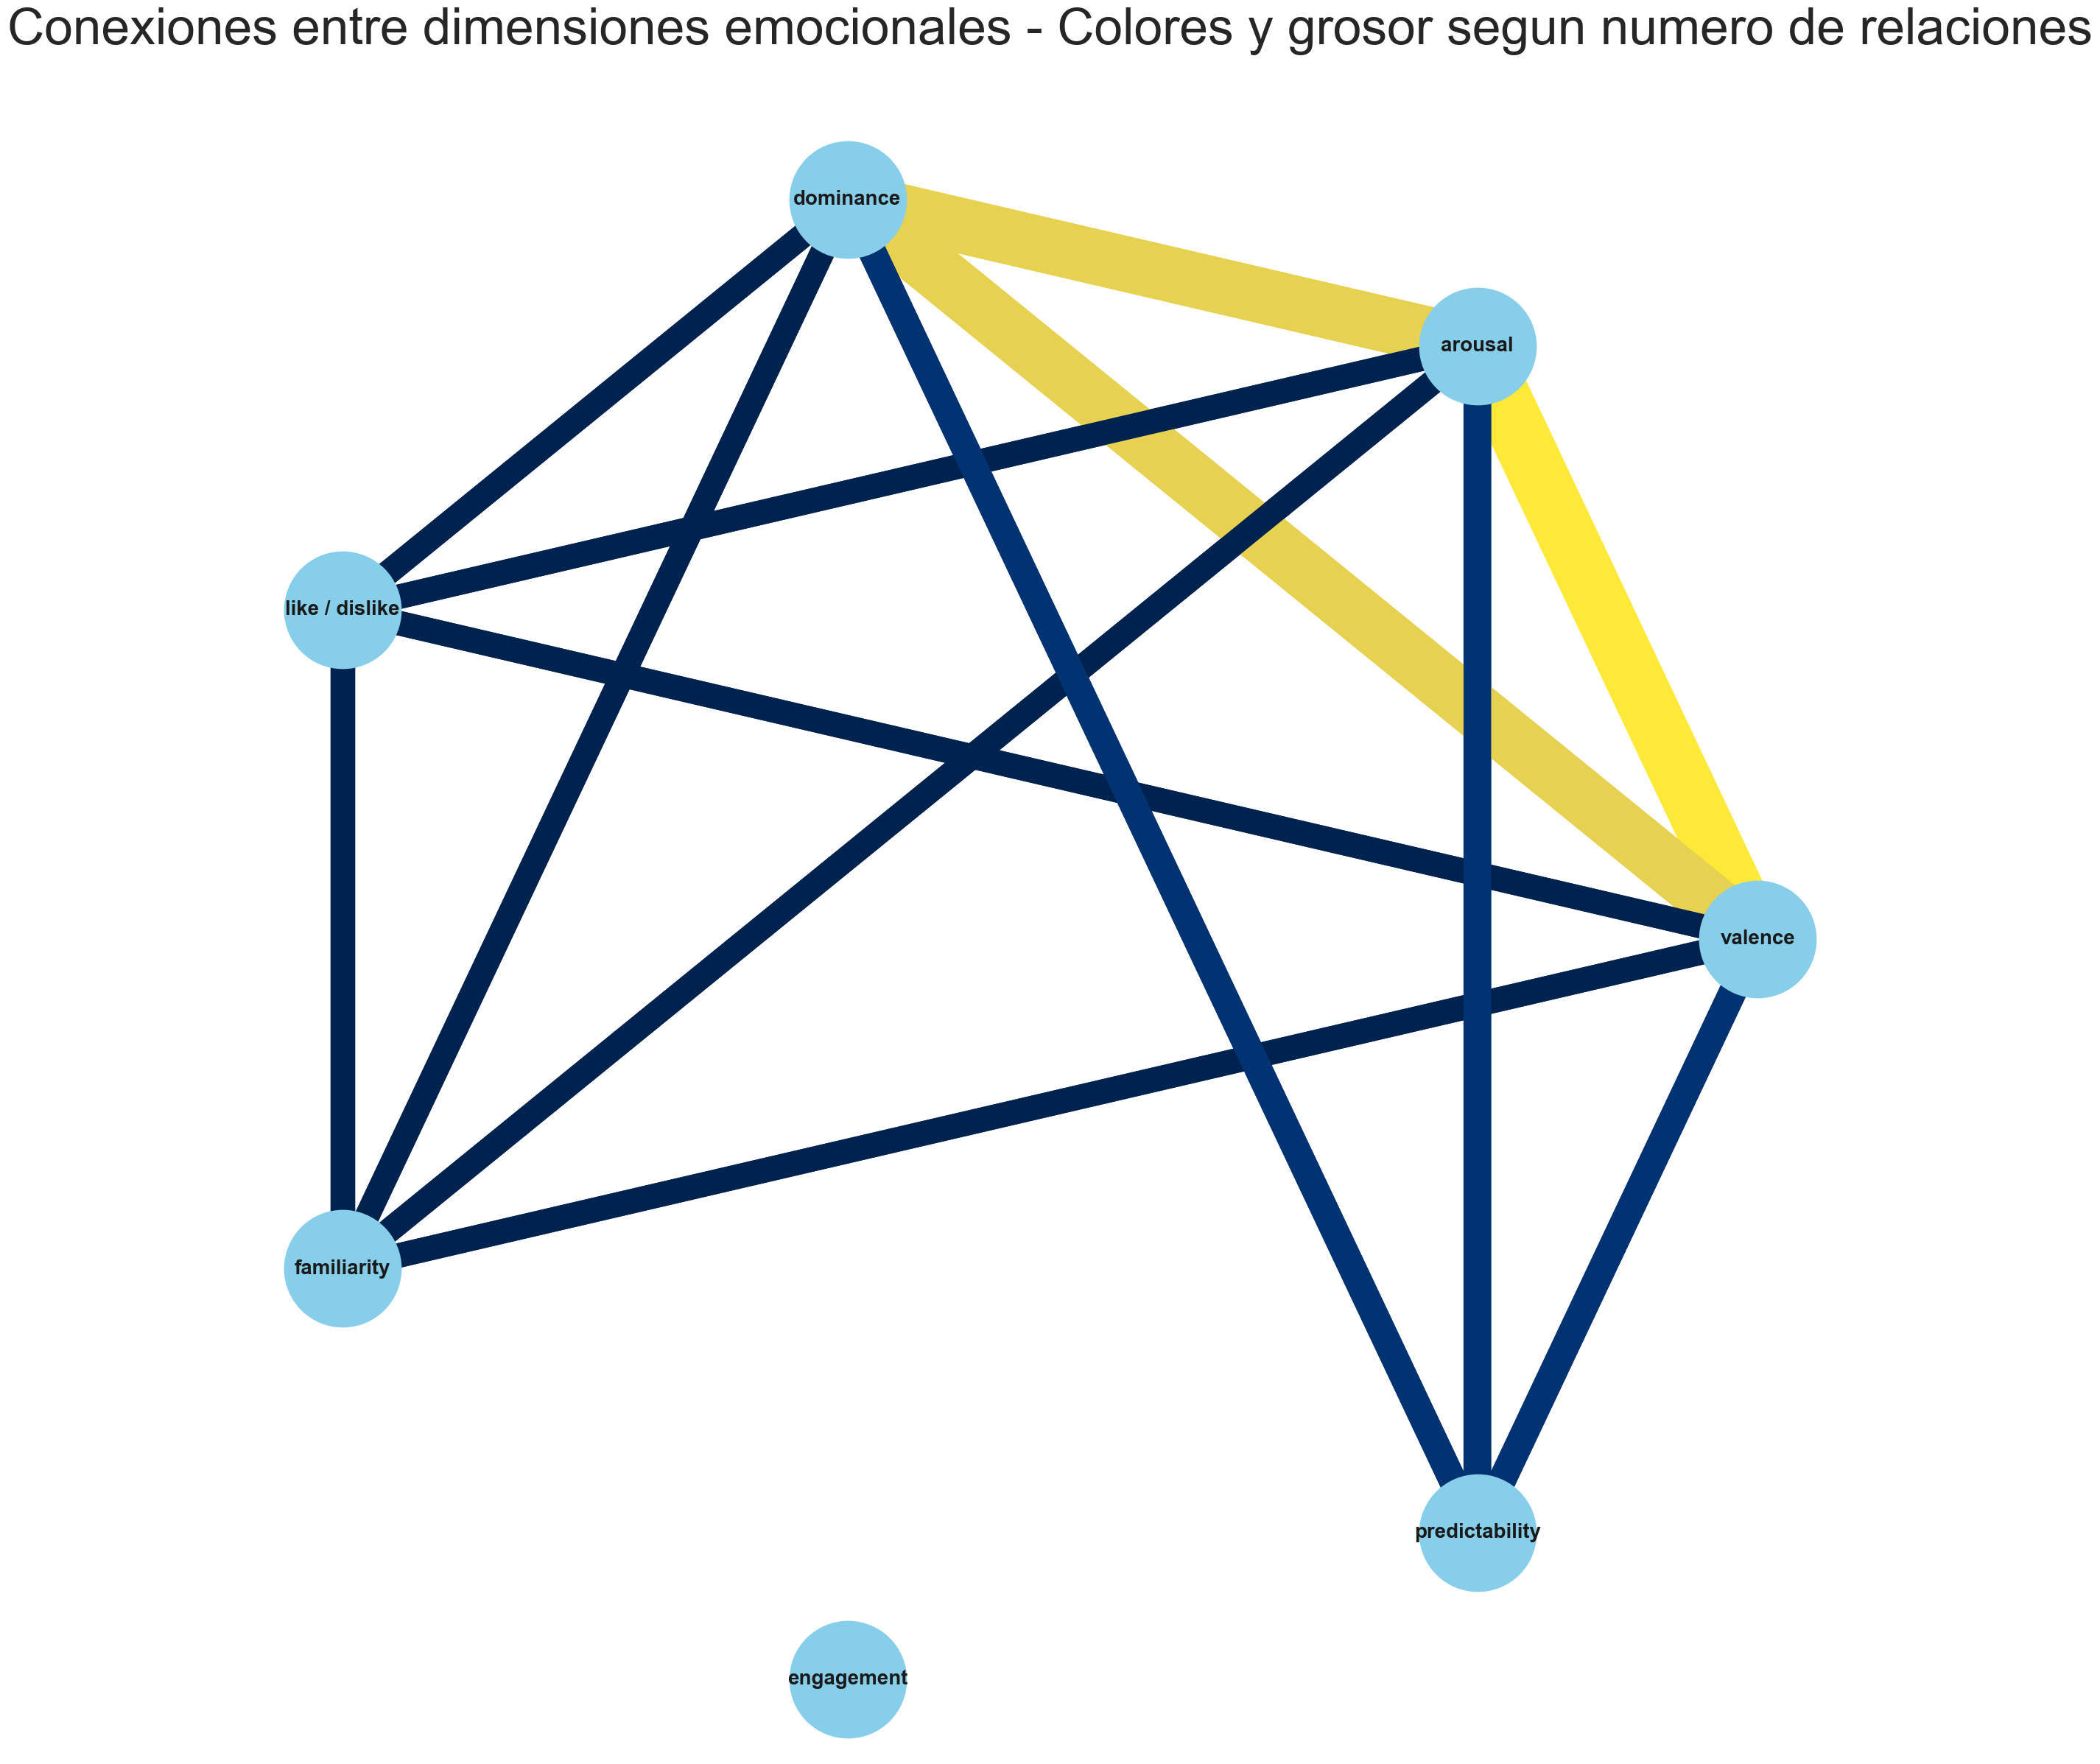

In [665]:

weights = nx.get_edge_attributes(Gd,'weight').values()

fig, ax = plt.subplots(figsize=(30, 30))

pos = nx.circular_layout(Gd)

plt.title('Conexiones entre dimensiones emocionales - Colores y grosor segun numero de relaciones', fontdict = {'fontsize' : 50})

nx.draw(Gd, pos, 
        edge_color=weights, 
        node_color='skyblue',
        width=[i*3 for i in weights],
        with_labels=True,
        node_size=13000,
        alpha=1,
        font_size=20,
        font_weight="bold",
        arrows=False,
        edge_cmap=plt.colormaps['cividis'])

plt.savefig('.\\Emmanuel\\figures\\NUEVOS. Conexiones entre dimensiones emocionales - Colores y grosor segun numero de relaciones.png')

In [666]:
relaciones(weights)

Interacciones con 8 conexiones se observaron 7.0 veces.
Interacciones con 9 conexiones se observaron 3.0 veces.
Interacciones con 18 conexiones se observaron 2.0 veces.
Interacciones con 19 conexiones se observaron 1.0 veces.


### ¿Cual es la frecuencia del uso de modelos algoritmicos de regresion y clasificacion?
3. Gráficos frencuencia de los modelos algoritimicos, según modelos de regresión y clasificación

- Interpretaciones: Los algoritmos clasificadores son por mucho los mas usados, ademas de ser los que mas variedad representan. Que implica esto? Es lo mismo aplicar algoritmos clasificadores o regresores?
- Nota: ordenar los valores de los gráficos y unirlos en uno, buscar graficar los mas usados (primeros 5 o 10) 

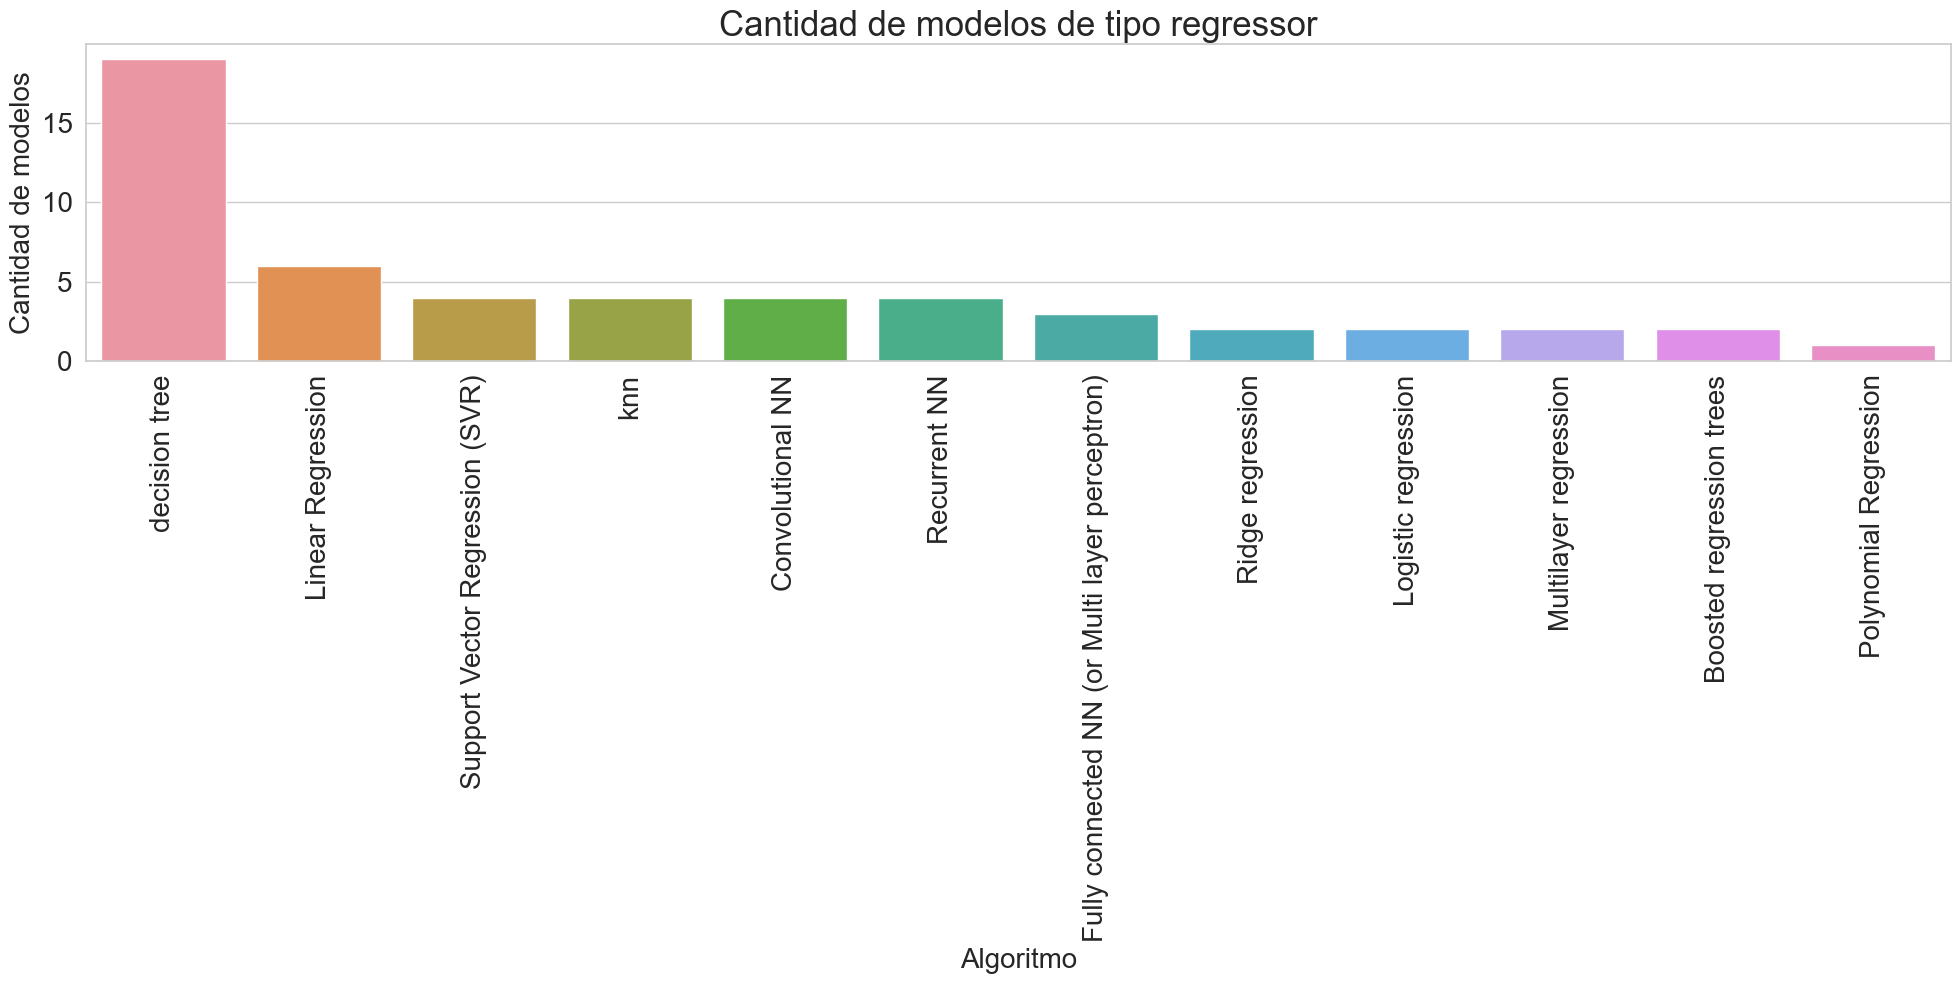

In [667]:
df_statistical_learning_models = df_statistical_learning_models.fillna('-')

#para regressor
df_algoritmos_regre = multi_reversing(df_statistical_learning_models, 'model_id', df_statistical_learning_models.iloc[:,43:57])
df_algoritmos_regre['variable'] = df_algoritmos_regre['variable'].str.replace('regre_','')

titulos = ['Cantidad de modelos de tipo regressor', 'Algoritmo', 'Cantidad de modelos']
bar_plot('variable',df_algoritmos_regre,titulos)

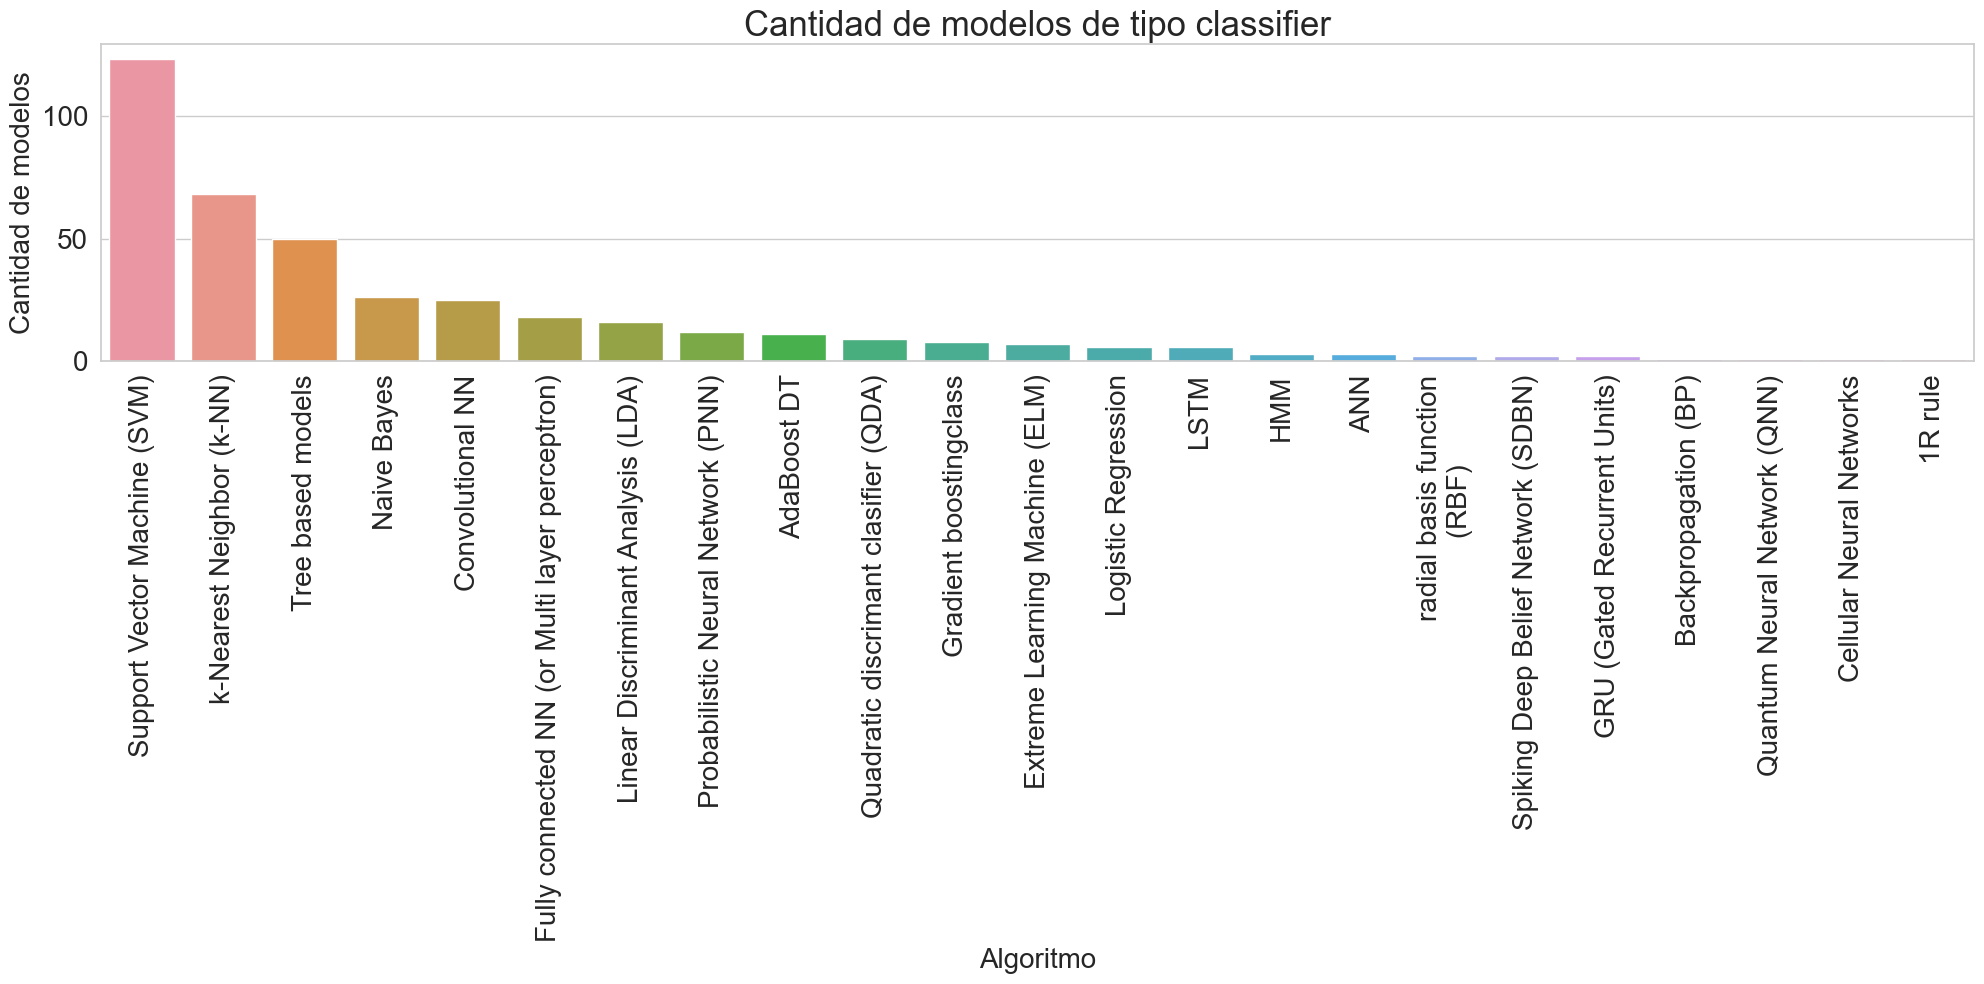

In [668]:
#para classifier

df_algoritmos_class = multi_reversing(df_statistical_learning_models, 'model_id', df_statistical_learning_models.iloc[:,8:40])
df_algoritmos_class['variable'] = df_algoritmos_class['variable'].str.replace('class_','')

#Lista de algoritmos unicos de clasificacion
algoritmos_de_clasificacion = df_algoritmos_class["variable"].unique()
#print(algoritmos_de_clasificacion)

titulos = ['Cantidad de modelos de tipo classifier', 'Algoritmo', 'Cantidad de modelos']
bar_plot('variable',df_algoritmos_class,titulos)

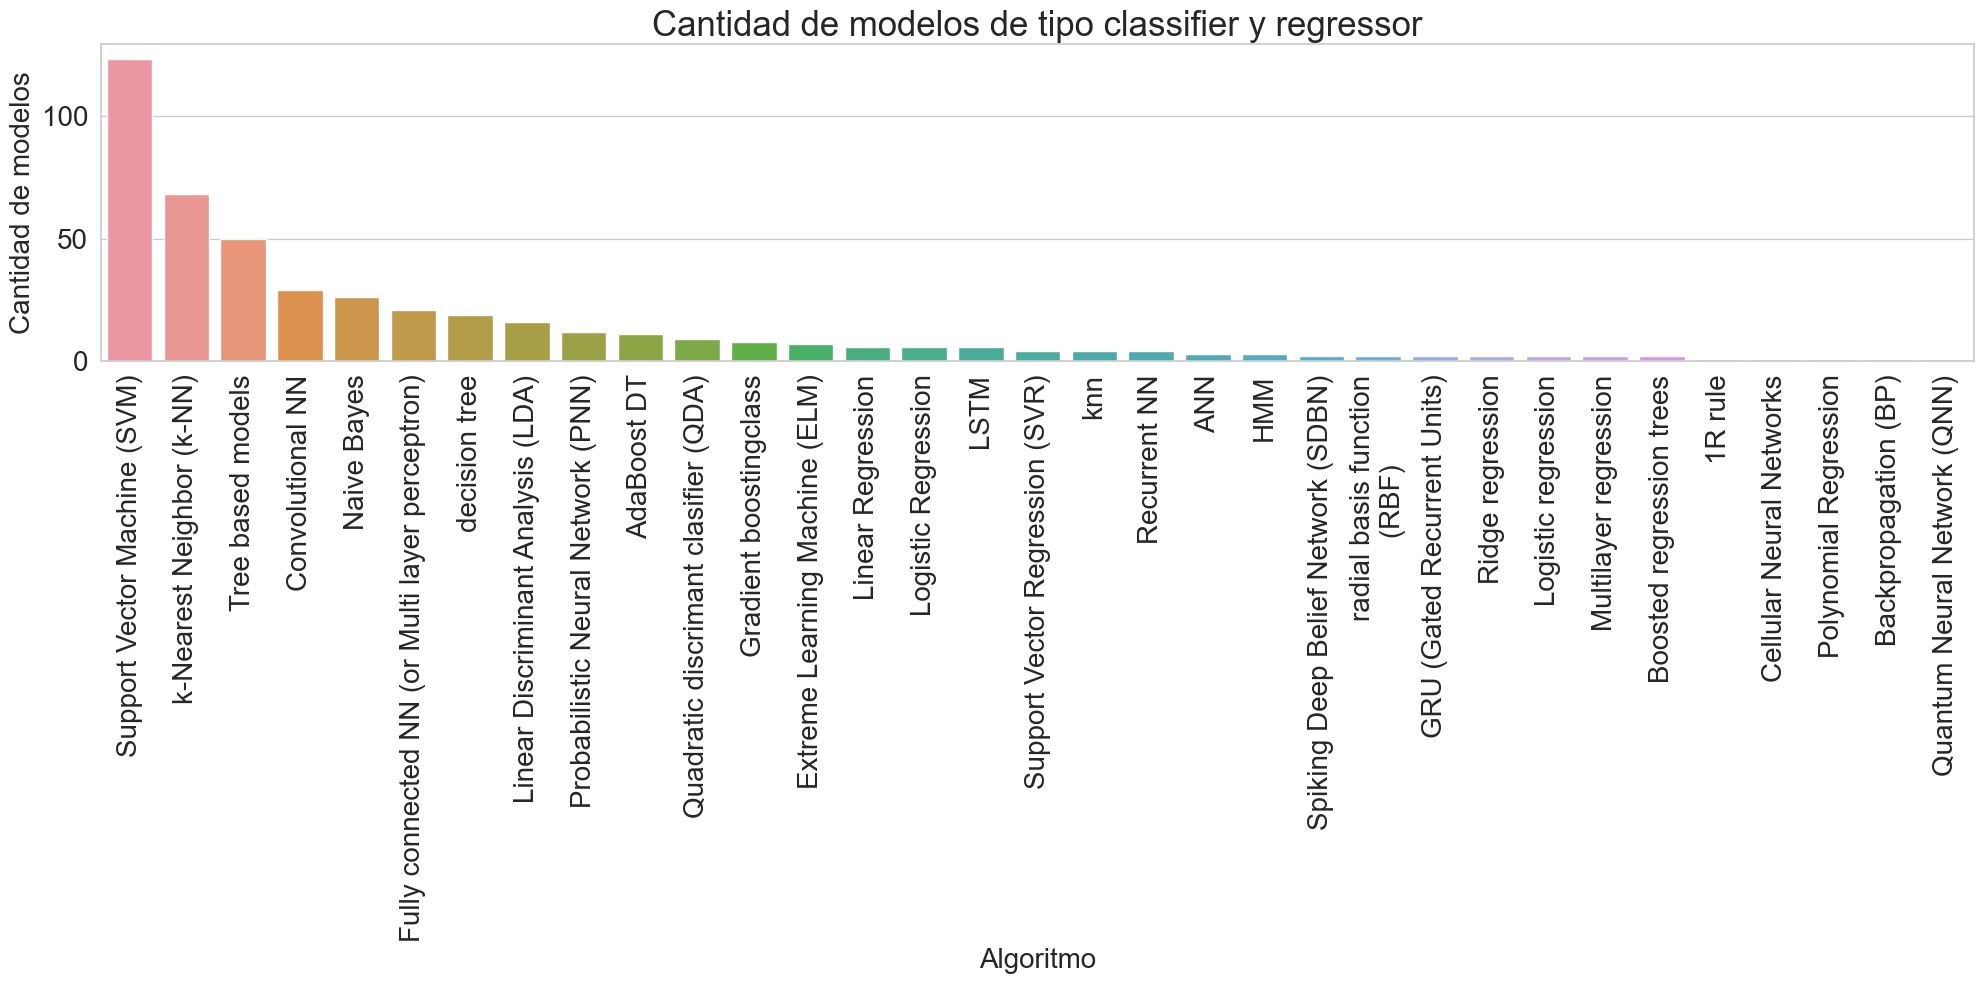

In [669]:
df_all_models = df_statistical_learning_models.iloc[:,1:57]
df_all_models.drop(df_all_models.columns[[1,2,3,4,5,6,39,40,41]], axis=1, inplace=True)

df_all_models = multi_reversing(df_all_models, 'model_id', df_all_models.iloc[:,1:])
df_all_models['variable'] = df_all_models['variable'].str.replace('class_','')
df_all_models['variable'] = df_all_models['variable'].str.replace('regre_','')

titulos = ['Cantidad de modelos de tipo classifier y regressor', 'Algoritmo', 'Cantidad de modelos']
bar_plot('variable',df_all_models,titulos)

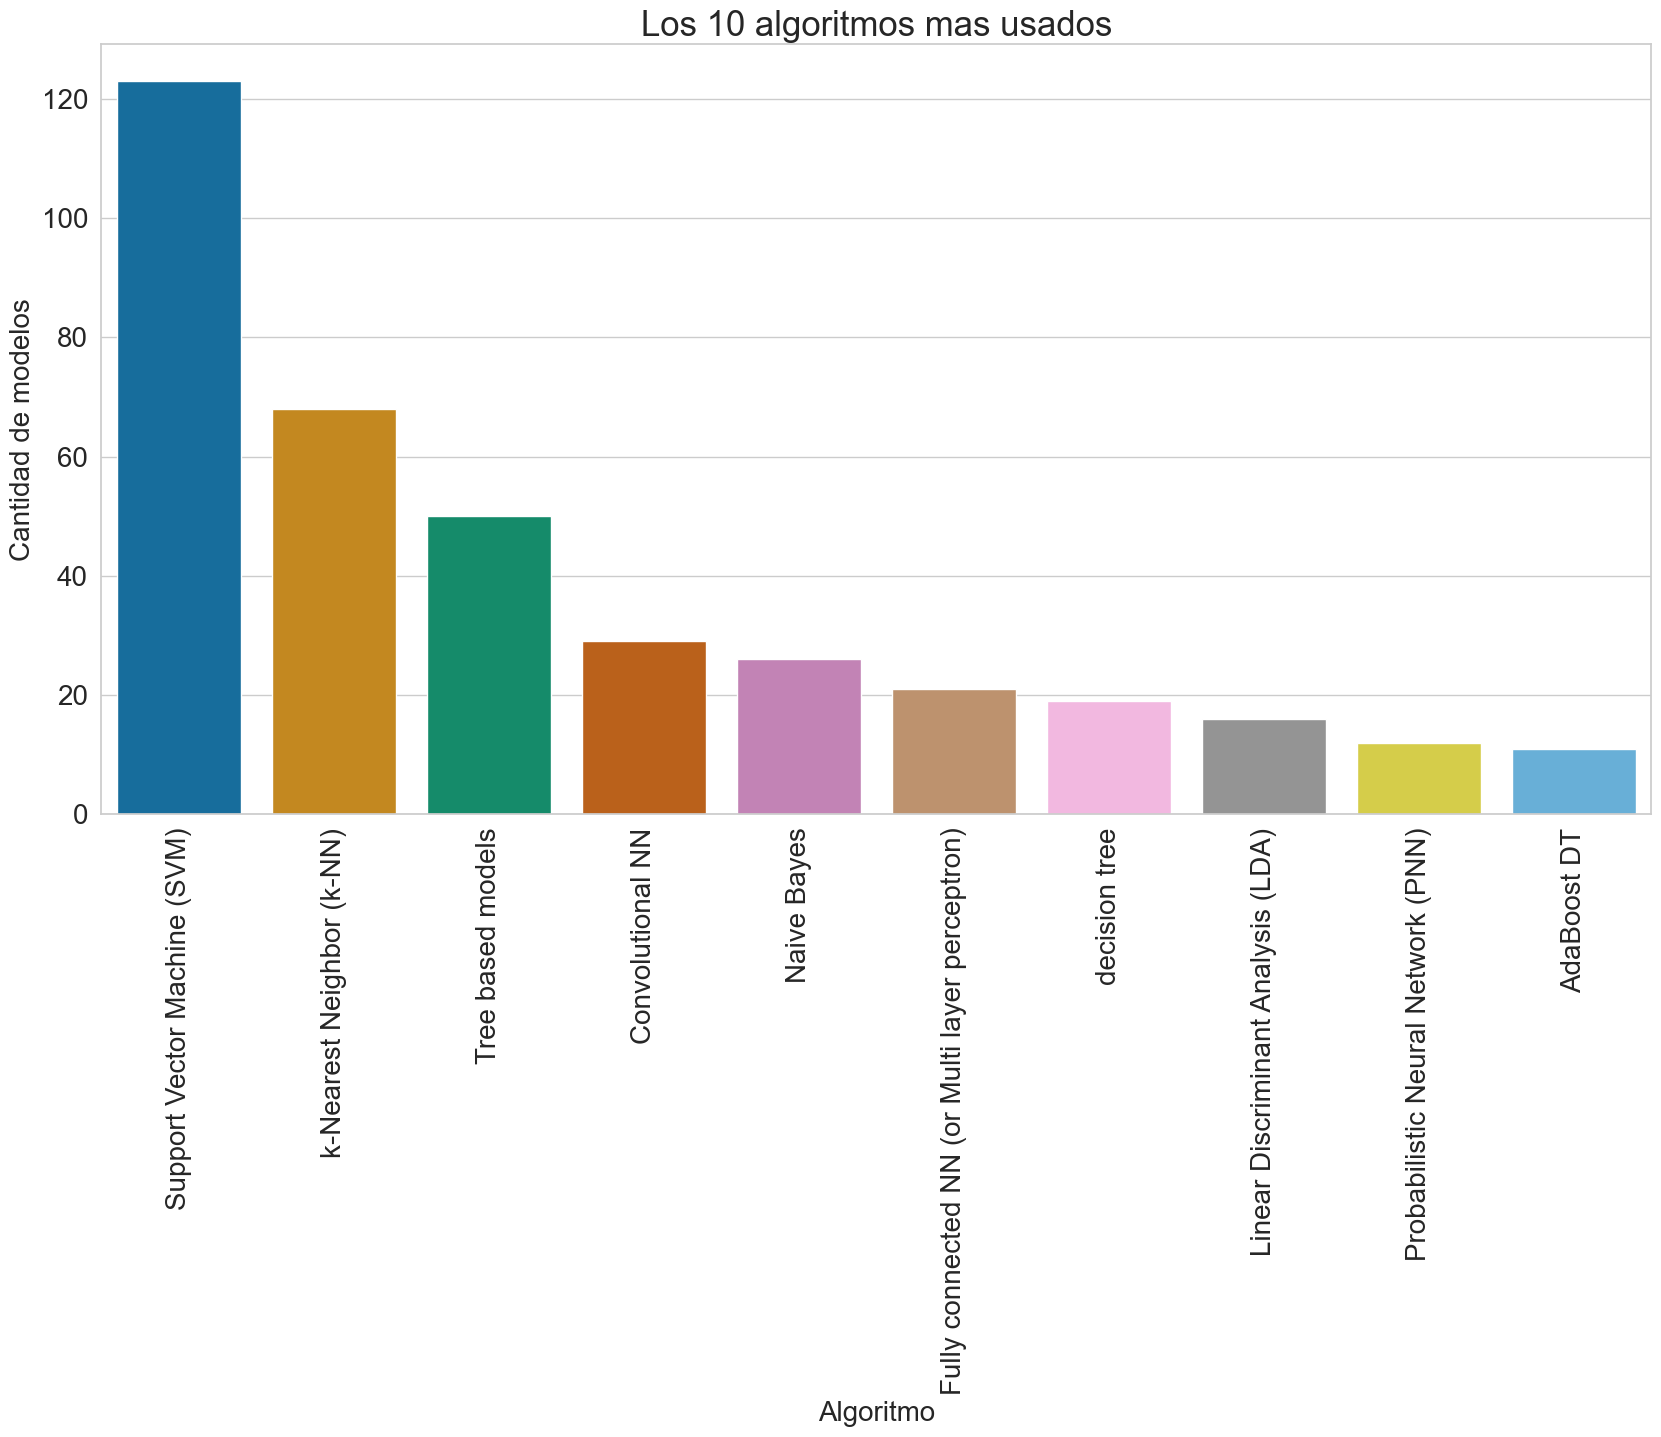

In [670]:
vc = df_all_models['variable'].value_counts()
vc = vc.iloc[:10]
df_dv = vc.to_frame()
df_dv = df_dv.reset_index()
df_dv.rename(columns = {'index':'algoritmo', 'variable':'cantidad'}, inplace = True)

titulos = ['Los 10 algoritmos mas usados', 'Algoritmo', 'Cantidad de modelos']
g = sns.barplot(data=df_dv, x='algoritmo', y='cantidad')
g.set(title = titulos[0], xlabel = titulos[1], ylabel = titulos[2])
plt.xticks(rotation=90)
plt.savefig('.\\Emmanuel\\figures\\NUEVOS. Los 10 algoritmos mas usados.png')

In [671]:
"""df_class_or_regre['variable'] = df_class_or_regre['variable'].str.replace('is_','')
df_class_or_regre["variable"].value_counts(normalize=True).mul(100).round(1).astype(str) + '%'"""

'df_class_or_regre[\'variable\'] = df_class_or_regre[\'variable\'].str.replace(\'is_\',\'\')\ndf_class_or_regre["variable"].value_counts(normalize=True).mul(100).round(1).astype(str) + \'%\''

In [672]:
"""#pie plot
quantity = df_class_or_regre['variable'].value_counts()
df_class_or_regre_quantity = pd.DataFrame(quantity)

names = 'Classifier', 'Regressor'
plt.pie(df_class_or_regre_quantity['variable'], labels = names, labeldistance = 1.15, wedgeprops = { 'linewidth' : 3, 'edgecolor' : 'white' })
plt.savefig('.\\Emmanuel\\figures\\NUEVOS. Proporcion uso de modelos de regresion y clasificacion.png')"""

"#pie plot\nquantity = df_class_or_regre['variable'].value_counts()\ndf_class_or_regre_quantity = pd.DataFrame(quantity)\n\nnames = 'Classifier', 'Regressor'\nplt.pie(df_class_or_regre_quantity['variable'], labels = names, labeldistance = 1.15, wedgeprops = { 'linewidth' : 3, 'edgecolor' : 'white' })\nplt.savefig('.\\Emmanuel\\figures\\NUEVOS. Proporcion uso de modelos de regresion y clasificacion.png')"

### ¿Cual es la evolucion temporal (2010-2020) del uso de las bases de datos privadas y publicas?
5. Gráfico de barra por año (2010-2020) según tipos de base de datos (privada, pública)

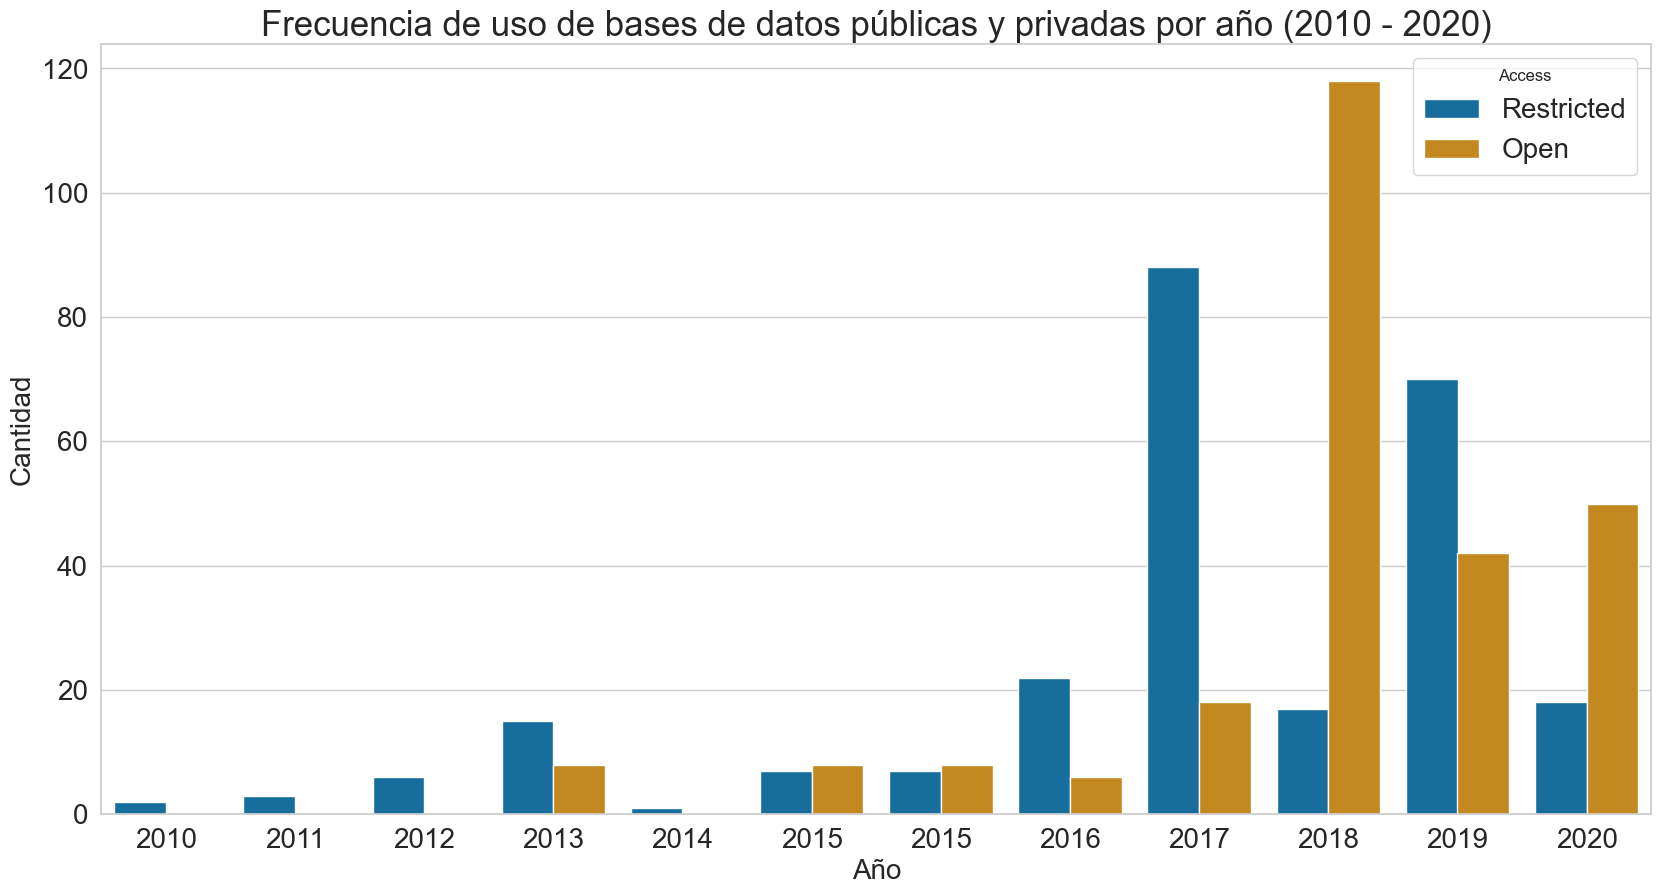

In [673]:
#rellenar datos faltantes y dropeo de duplicados
df_data_type=df_data_type.fillna('-')
df_data_type_sin_duplicates = df_data_type.drop_duplicates(subset='paper_id')
df_data_type["db_access"] = df_data_type["db_access"].str.capitalize()
df_data_type = df_data_type.rename(columns={"db_access":"Access"})

category_order = [2010, 2011, 2012, 2013, 2014, 2015, 2015, 2016, 2017, 2018, 2019, 2020]
g = sns.countplot(x='year', 
    data= df_data_type, 
    hue='Access', 
    order=category_order)
g.set(title = 'Frecuencia de uso de bases de datos públicas y privadas por año (2010 - 2020)', xlabel = 'Año', ylabel = 'Cantidad')
plt.savefig('.\\Emmanuel\\figures\\NUEVOS. Frecuencia de uso de bases de datos públicas y privadas por año (2010 - 2020).png')

### ¿Cual es la frecuencia de uso de cada bse de datos encontrada?

6. Gráfico frencuencia de uso de cada base de datos pública encontrada
- Interpretacion: Un predominio de pocas bases de datos. Estamos todo el tiempo sacando conclusiones sobre los mismos sujetos? Ver predominio de bases de datos publicas por sobre las privadas
- No se ha tenido en cuenta el dato aportado por Lorenzo (mas de una db por paper)

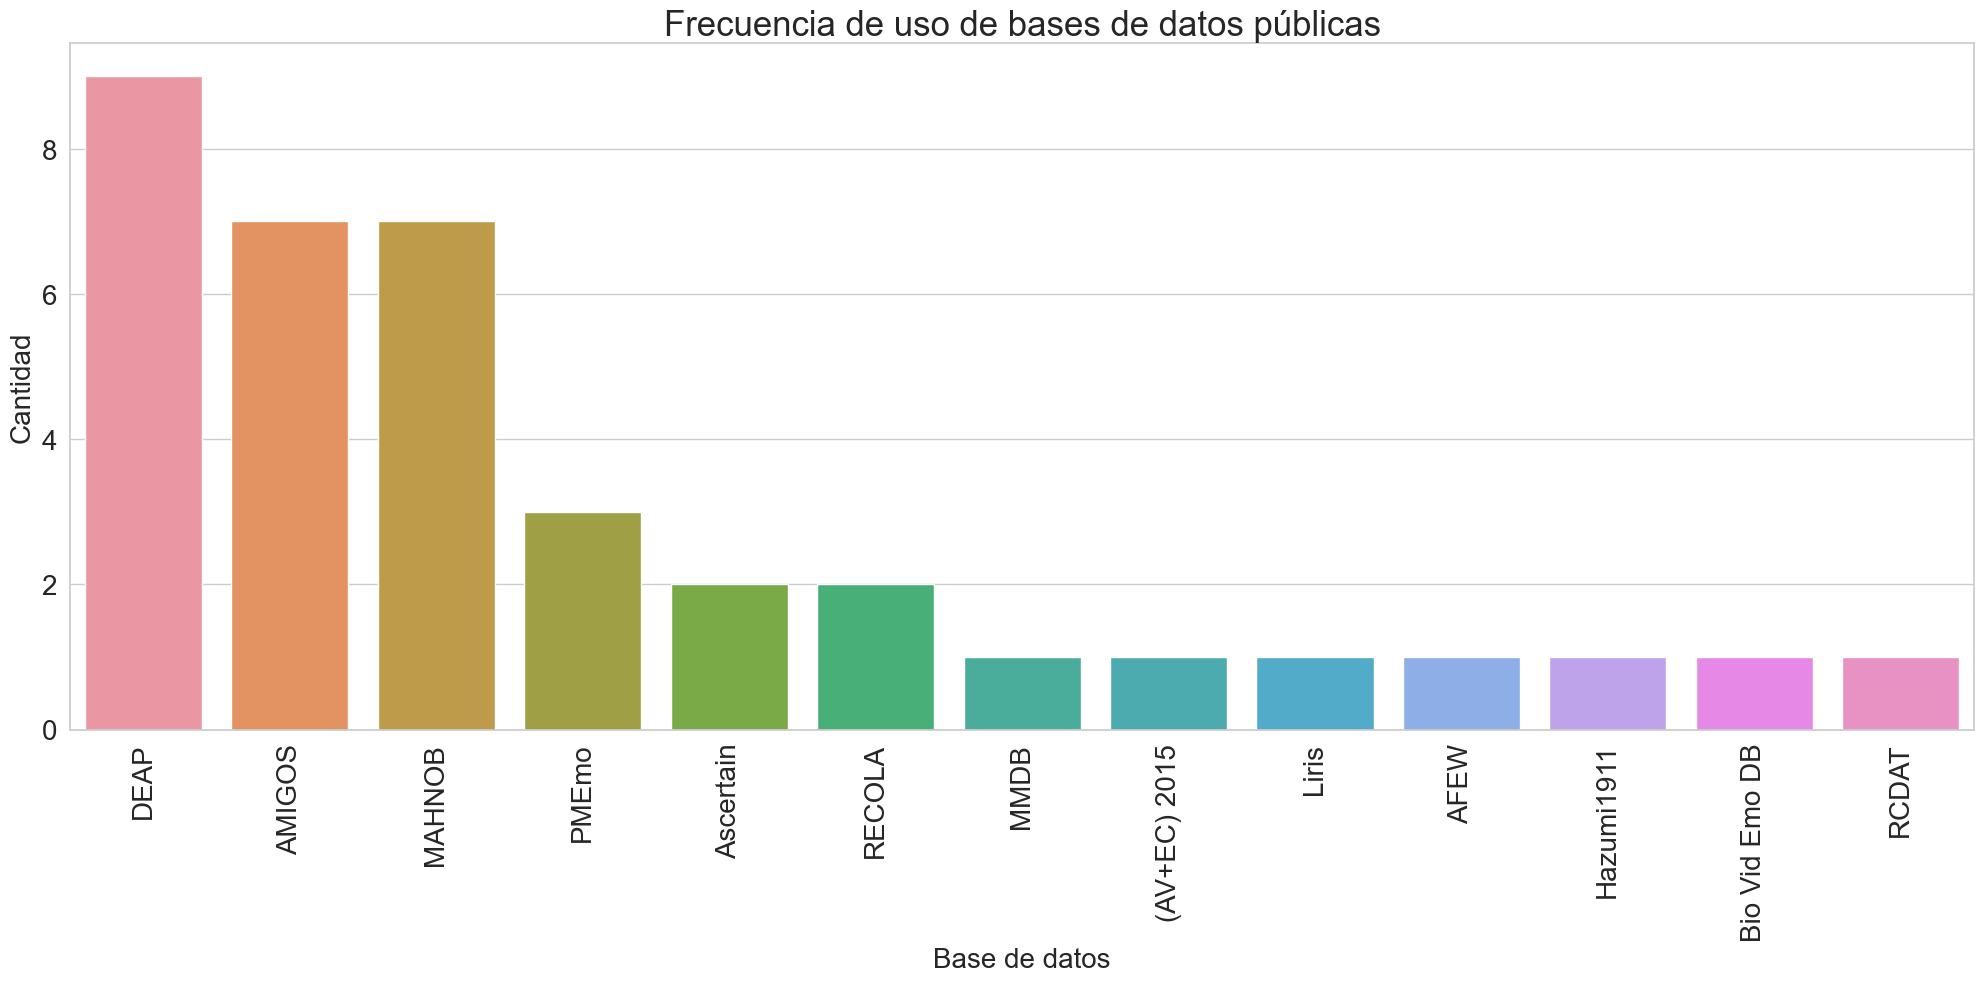

In [674]:
#bases de datos
df_data_type=df_data_type.fillna('-')
df_data_type_sin_duplicates = df_data_type.drop_duplicates(subset='paper_id')

df_db = multi_reversing(df_data_type_sin_duplicates, 'paper_id', df_data_type_sin_duplicates.iloc[:,12:])

df_db = df_db.replace('Multimodal Dyadic Behavior (MMDB)', 'MMDB')

titulos = ['Frecuencia de uso de bases de datos públicas', 'Base de datos', 'Cantidad']
bar_plot('variable',df_db,titulos)

### ¿De que revistas cientificas provinieron la mayoria de los papers? ¿Cual era su orientacion (psicologica o ingenieria de datos)?
7. Gráfico frecuencia de papers según revista científica de origen, distinguiendo entre las que poseen orientación en ingeniería de datos y las que no

Nota: falta filtrar bien cuales son journal, y cuales de estas son de ingenieria o no (diferenciarlas con color o hue)

C:\Users\someo\AppData\Local\Temp\ipykernel_33180\4083952796.py:33: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all axes decorations.
  plt.tight_layout()


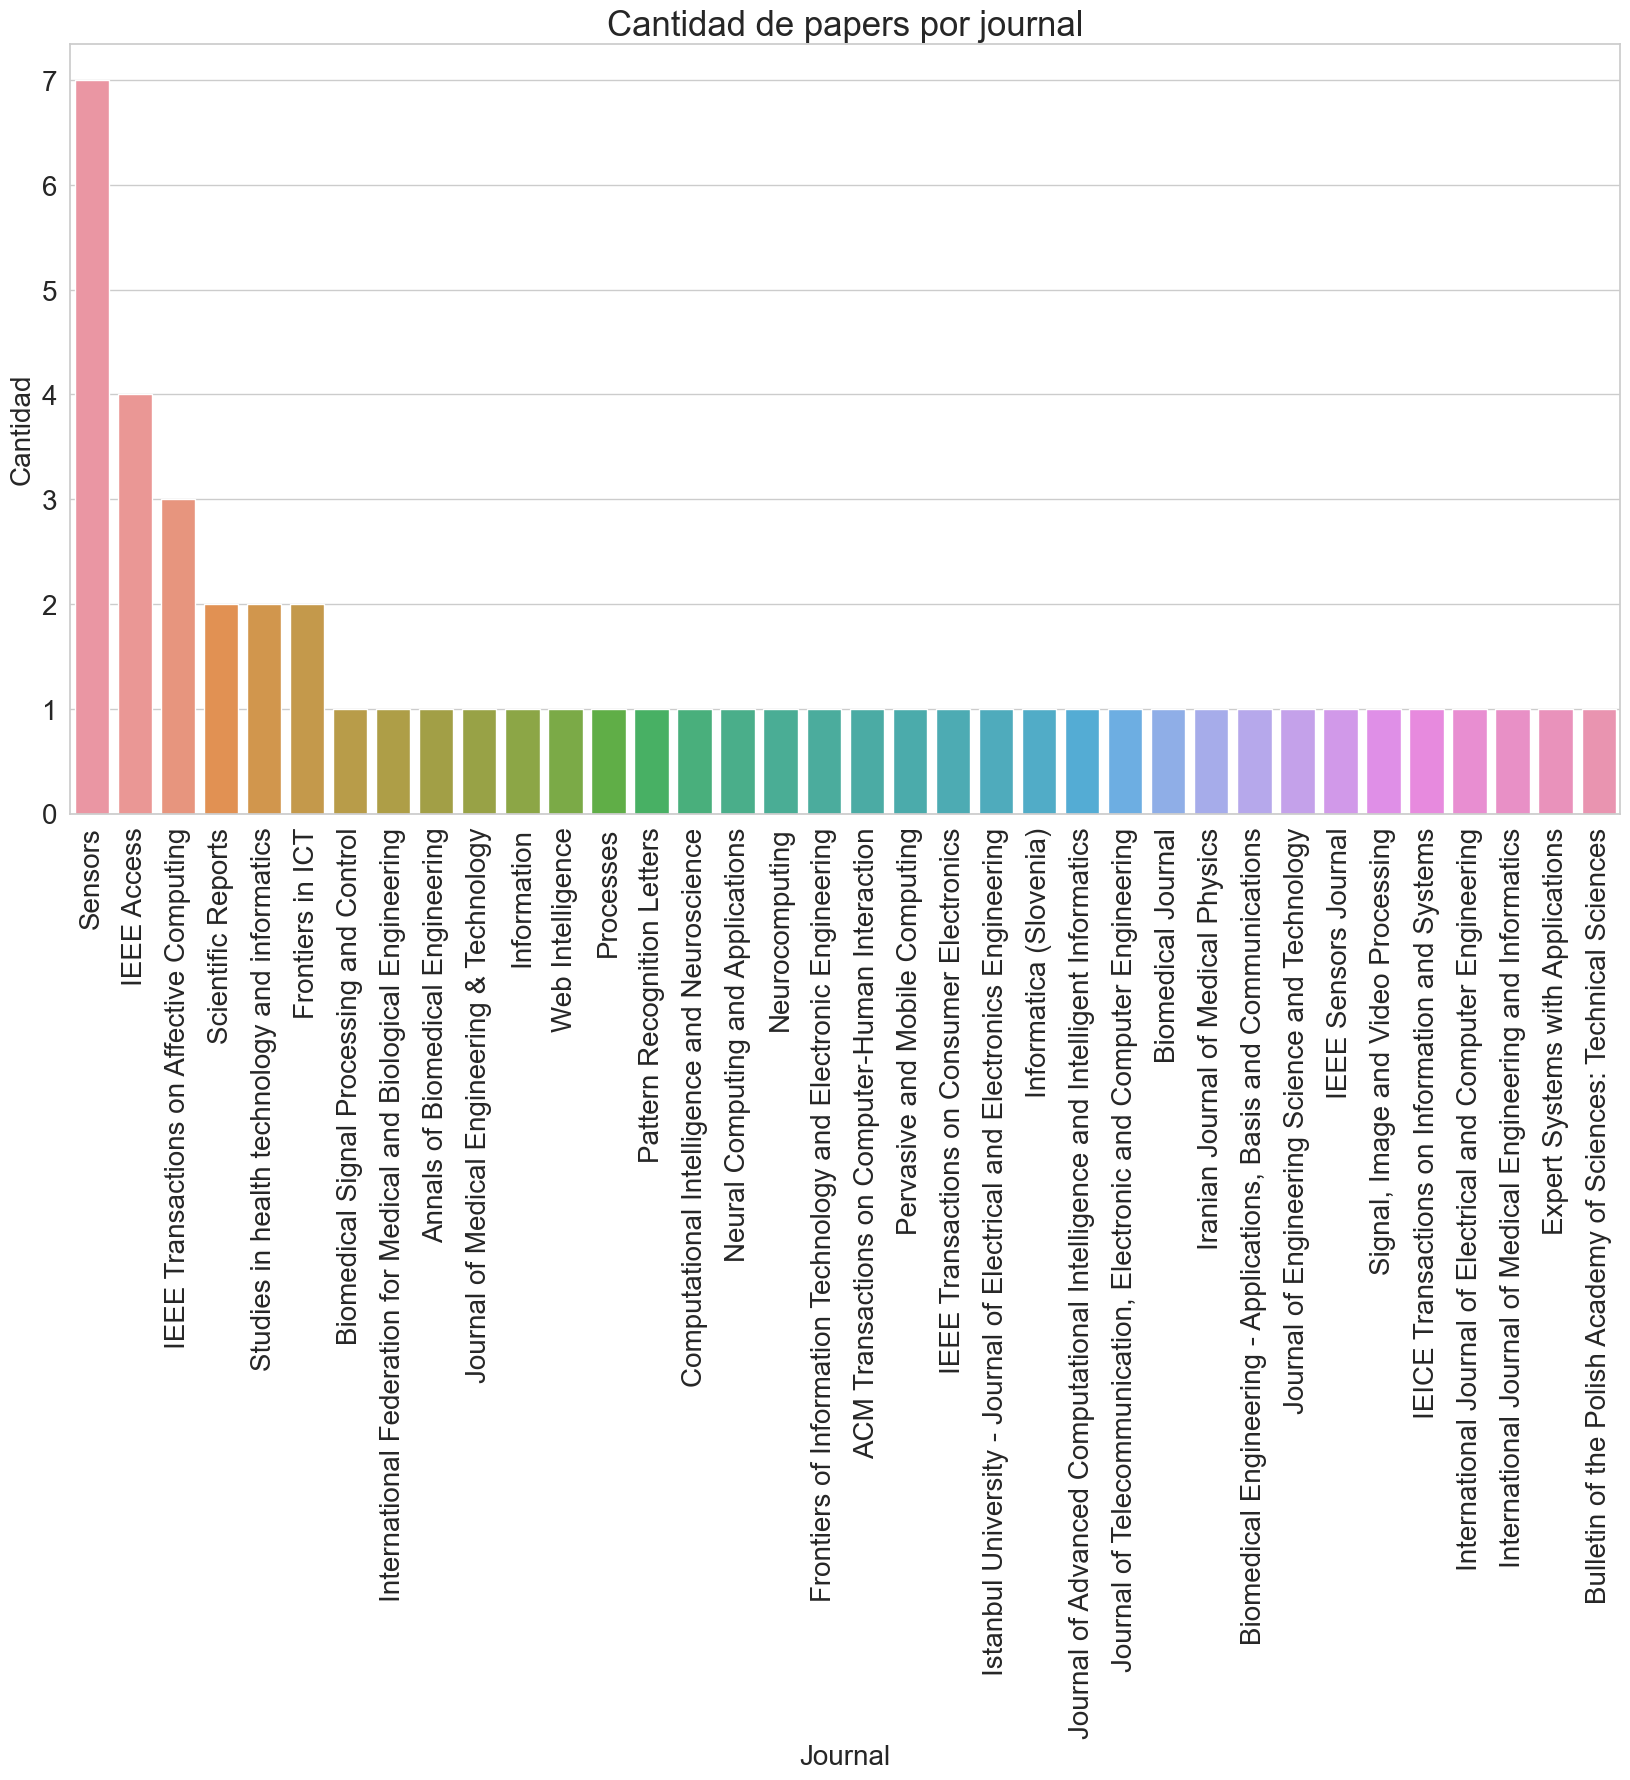

In [675]:
#por revista
df_metadata=df_metadata.fillna('-')
df_metadata_sin_duplicates = df_metadata.drop_duplicates(subset='paper_id')

df_source_title = df_metadata_sin_duplicates[['paper_id','source_title','source_type_journal']]
df_source_title = df_source_title[df_source_title['source_type_journal'].isin(['x', 'X'])] 

titulos = ['Cantidad de papers por journal', 'Journal', 'Cantidad']
bar_plot('source_title',df_source_title,titulos)

In [676]:
df_source_title["source_title"].value_counts()

Sensors                                                                       7
IEEE Access                                                                   4
IEEE Transactions on Affective Computing                                      3
Scientific Reports                                                            2
Studies in health technology and informatics                                  2
Frontiers in ICT                                                              2
Biomedical Signal Processing and Control                                      1
International Federation for Medical and Biological Engineering               1
Annals of Biomedical Engineering                                              1
Journal of Medical Engineering & Technology                                   1
Information                                                                   1
Web Intelligence                                                              1
Processes                               

In [677]:
df_source_title["source_title"].value_counts(normalize=True).mul(100).round(1).astype(str) + '%'

Sensors                                                                       14.0%
IEEE Access                                                                    8.0%
IEEE Transactions on Affective Computing                                       6.0%
Scientific Reports                                                             4.0%
Studies in health technology and informatics                                   4.0%
Frontiers in ICT                                                               4.0%
Biomedical Signal Processing and Control                                       2.0%
International Federation for Medical and Biological Engineering                2.0%
Annals of Biomedical Engineering                                               2.0%
Journal of Medical Engineering & Technology                                    2.0%
Information                                                                    2.0%
Web Intelligence                                                            

In [678]:
serie_sources = df_source_title["source_title"].value_counts()
df_serie_sources = serie_sources.to_frame()
df_serie_sources = df_serie_sources.reset_index()
df_serie_sources.rename(columns = {'index':'algoritmo', 'variable':'cantidad'}, inplace = True)

In [679]:
col1 = df_serie_sources.columns[0]
col2 = df_serie_sources.columns[1]

mapping_others = {}

for i, row in df_serie_sources.iterrows():
    if row[col2] == 1:
        mapping_others.update({row[col1]: "Others (=1)"})

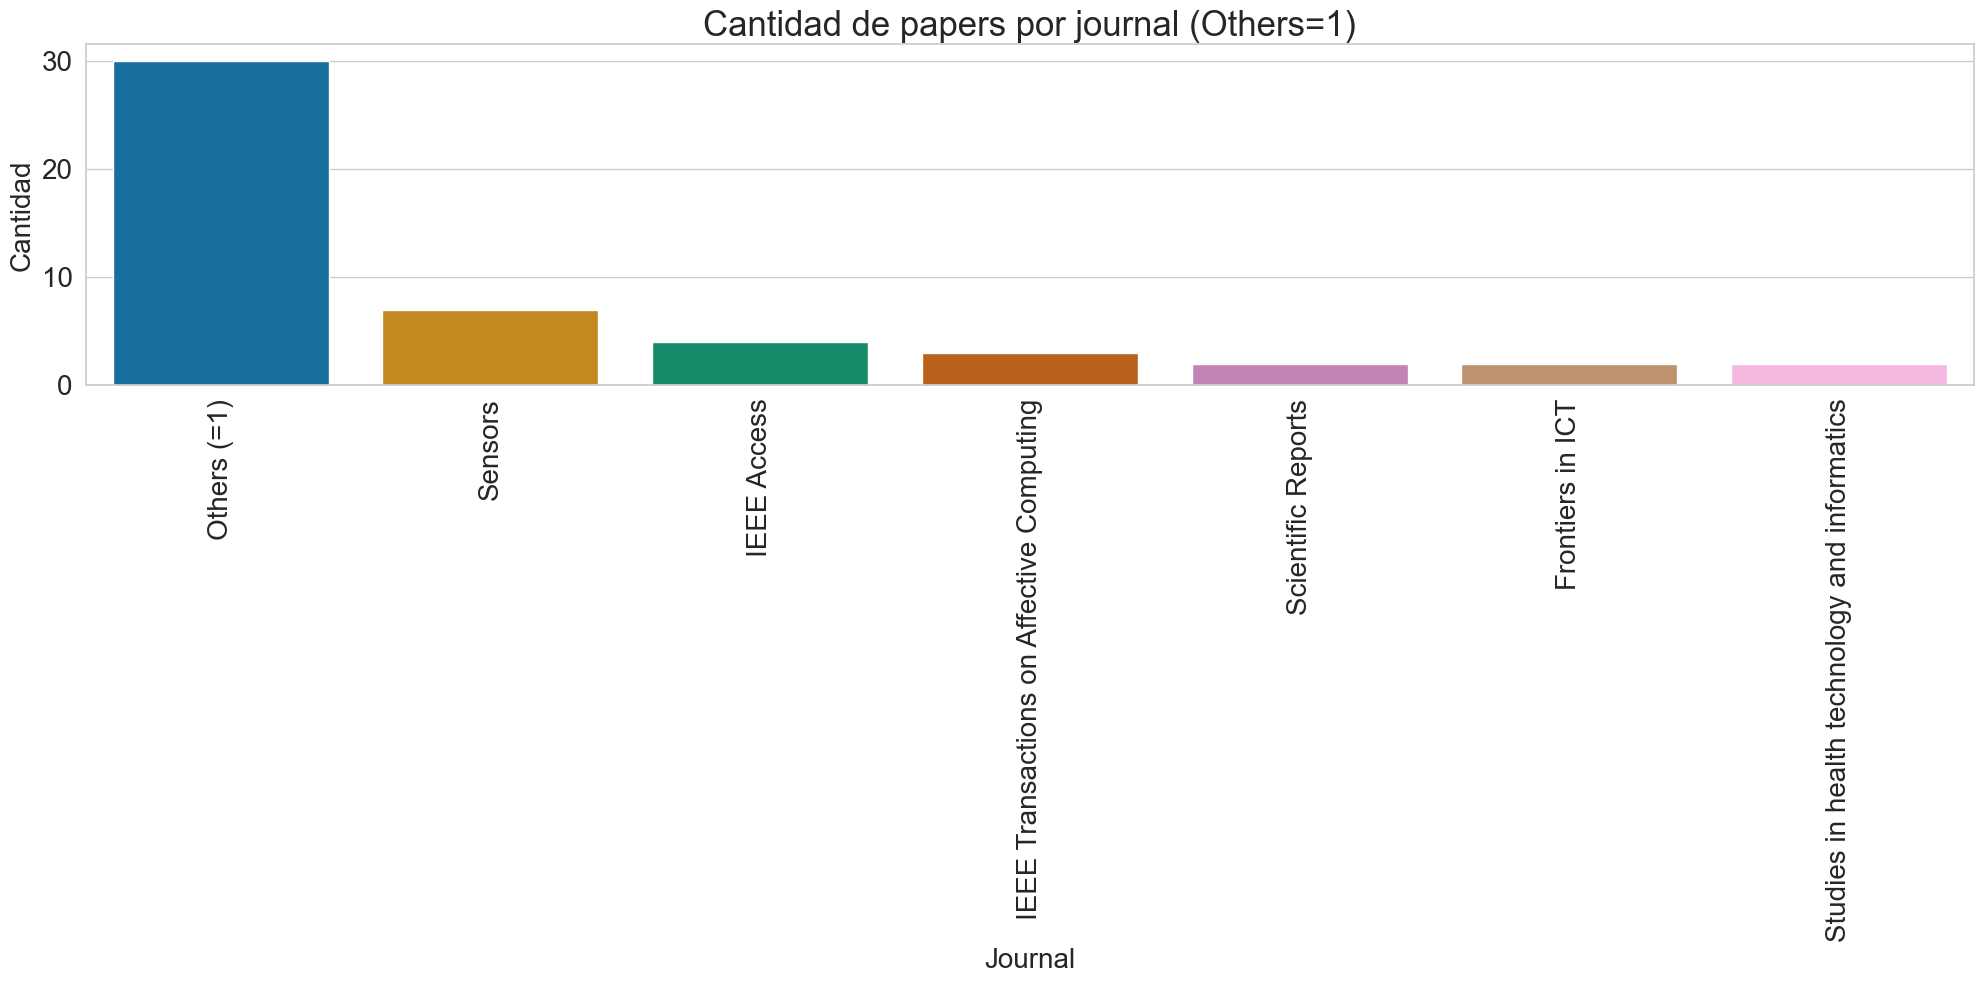

In [680]:
sources_with_others = df_source_title.copy()
sources_with_others.loc[:,'source_title'] = sources_with_others.loc[:,'source_title'].replace(mapping_others)
sources_with_others['source_title'].value_counts()

titulos = ['Cantidad de papers por journal (Others=1)', 'Journal', 'Cantidad']
bar_plot('source_title',sources_with_others,titulos)

In [681]:
sources_with_others["source_title"].value_counts()

Others (=1)                                     30
Sensors                                          7
IEEE Access                                      4
IEEE Transactions on Affective Computing         3
Scientific Reports                               2
Frontiers in ICT                                 2
Studies in health technology and informatics     2
Name: source_title, dtype: int64

In [682]:
sources_with_others["source_title"].value_counts(normalize=True).mul(100).round(1).astype(str) + '%'

Others (=1)                                     60.0%
Sensors                                         14.0%
IEEE Access                                      8.0%
IEEE Transactions on Affective Computing         6.0%
Scientific Reports                               4.0%
Frontiers in ICT                                 4.0%
Studies in health technology and informatics     4.0%
Name: source_title, dtype: object

# Plots para congreso

In [683]:
df_models = df_statistical_learning_models[["paper_id","apa_citation",'model', "year", "model_id"]]

df_models = df_models.groupby(
        ["paper_id",'model']
        ).nth(0)
df_models.reset_index(inplace=True)

In [684]:
palette_en = {
    'regressor': 'tab:blue',
    'classifier': 'tab:orange',
    'dimensional': 'tab:blue',
    'categorical': 'tab:orange'
}

palette_es = {
    'regresión': 'tab:blue',
    'clasificación': 'tab:orange',
    'dimensional': 'tab:blue',
    'categorial': 'tab:orange'
}

C:\Users\someo\AppData\Local\Temp\ipykernel_33180\2795071783.py:24: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax1.set_yticklabels(ax1.get_yticklabels(), size = 20)
C:\Users\someo\AppData\Local\Temp\ipykernel_33180\2795071783.py:25: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax2.set_yticklabels(ax2.get_yticklabels(), size = 20)


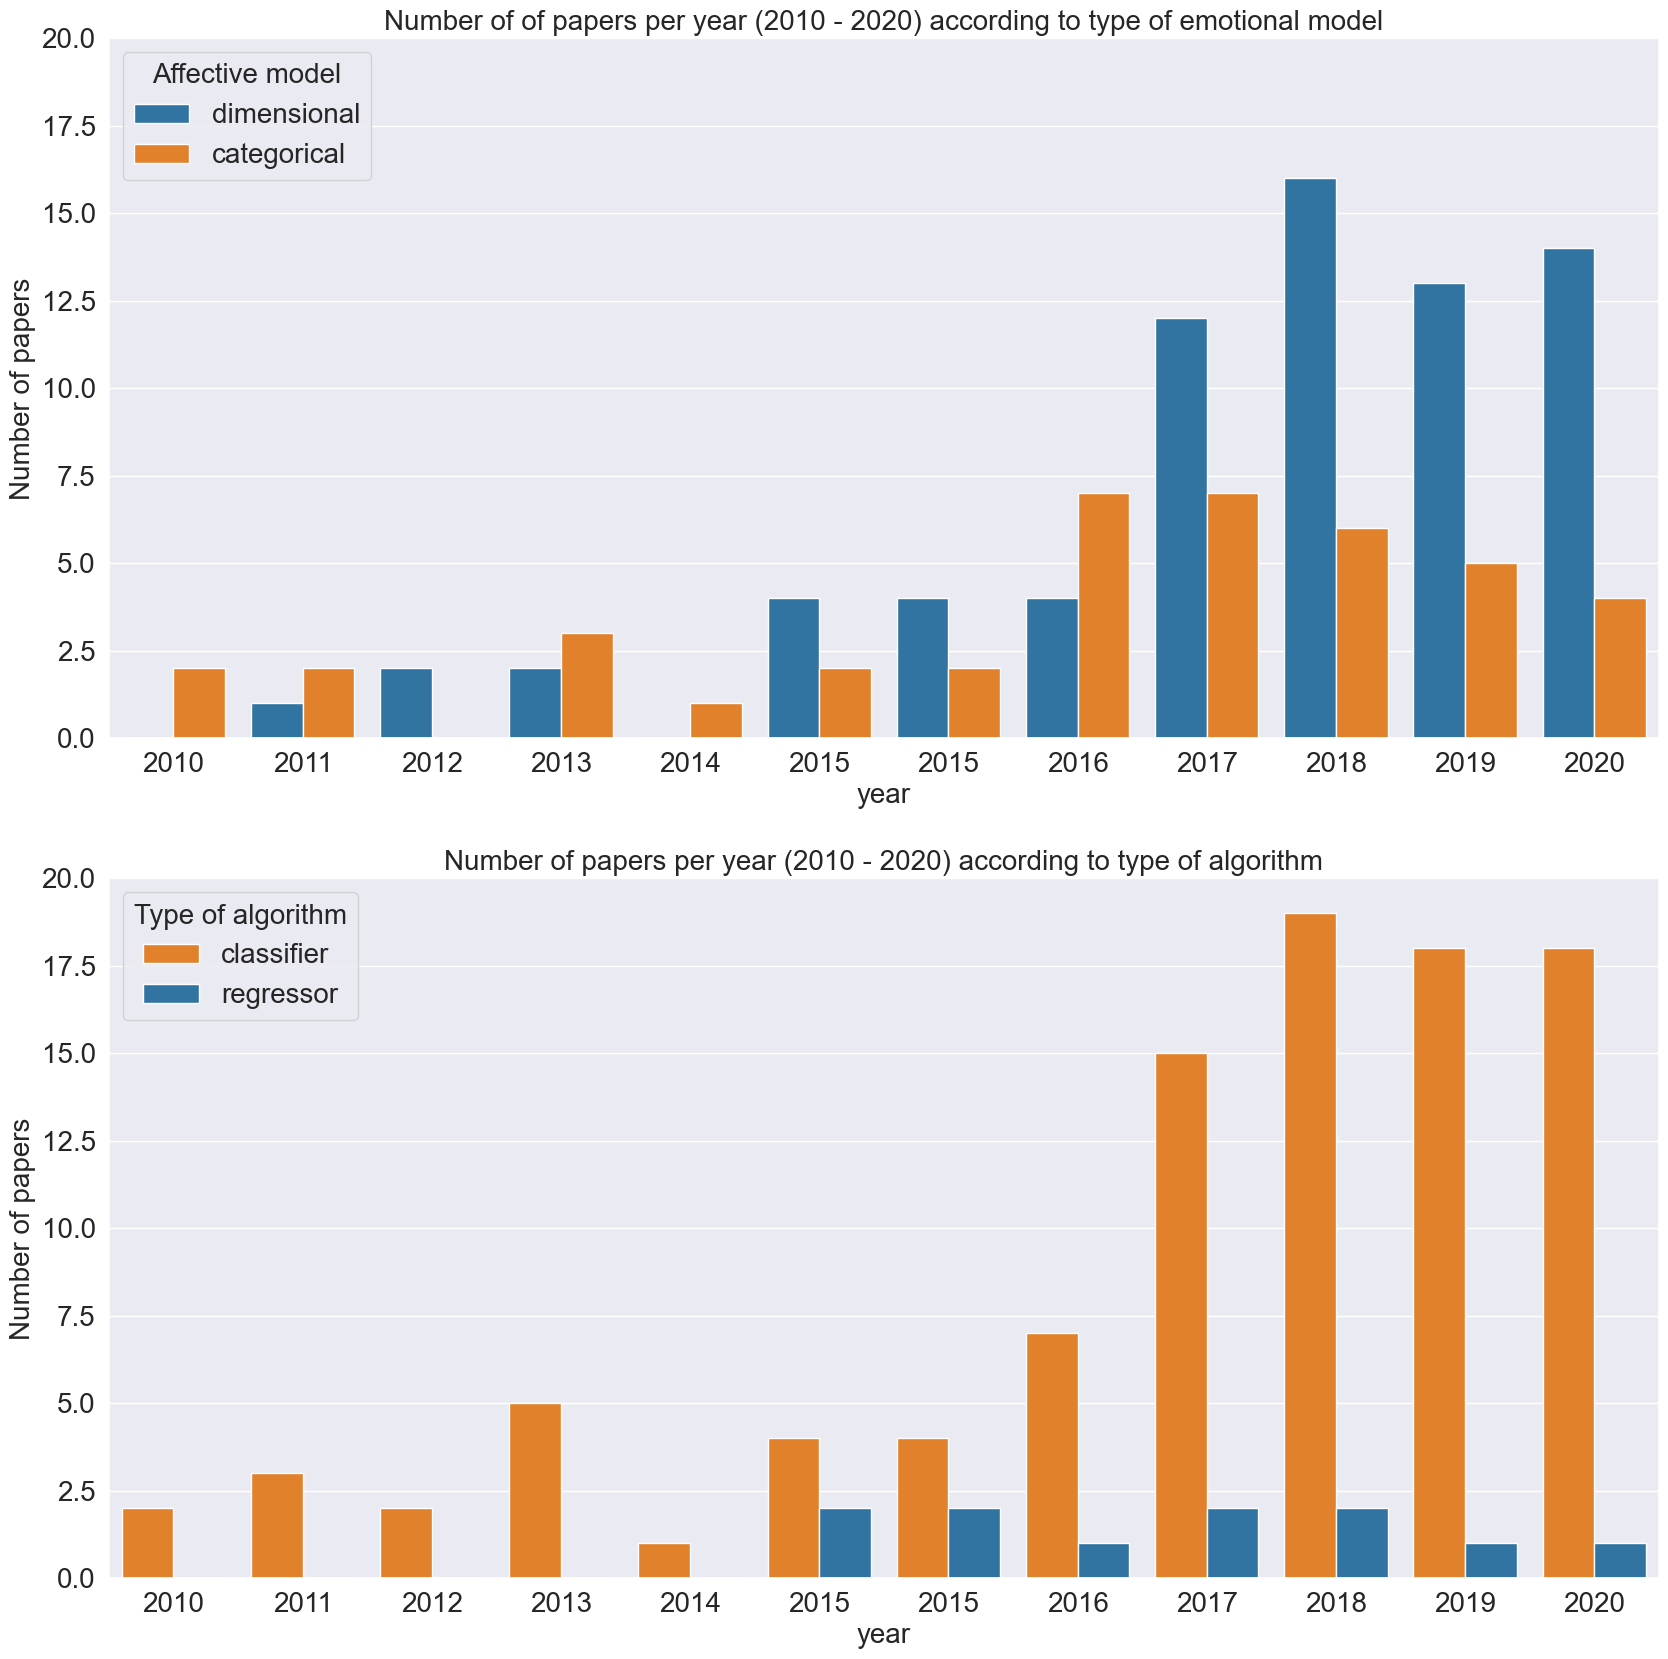

In [685]:
sns.set_style("darkgrid")
sns.set_palette('colorblind')
sns.set( rc = {'figure.figsize' : (20,20), 'axes.labelsize' : 20})

fig, axes = plt.subplots(2, 1)

ax1 = sns.countplot(x='year',
    data= df_statistical_learning_models_0, 
    hue='affective_model',
    palette = palette_en, 
    order=category_order, 
    ax=axes[0])

ax2 = sns.countplot(x='year', 
    data= df_models, 
    hue='model',
    palette = palette_en,
    order=category_order, 
    ax=axes[1])

ax1.set_ylim([0, 20])
ax2.set_ylim([0, 20])

ax1.set_yticklabels(ax1.get_yticklabels(), size = 20)
ax2.set_yticklabels(ax2.get_yticklabels(), size = 20)
ax1.set_xticklabels(category_order,fontsize = 20)
ax2.set_xticklabels(category_order,fontsize = 20)

ax1.set_ylabel("Number of papers")
ax2.set_ylabel("Number of papers")

ax1.set_title("Number of of papers per year (2010 - 2020) according to type of emotional model", fontsize = 20)
ax2.set_title("Number of papers per year (2010 - 2020) according to type of algorithm", fontsize = 20)

ax1.legend(title='Affective model', title_fontsize=20, loc='upper left',fontsize=20)
ax2.legend(title='Type of algorithm', title_fontsize=20, loc='upper left',fontsize=20)

In [686]:
df_statistical_learning_models_0['affective_model'] = df_statistical_learning_models_0['affective_model'].str.replace('dimensional','dimensional')
df_statistical_learning_models_0['affective_model'] = df_statistical_learning_models_0['affective_model'].str.replace('categorical','categorial')

In [687]:
df_models['model'] = df_models['model'].str.replace('classifier','clasificación')
df_models['model'] = df_models['model'].str.replace('regressor','regresión')

C:\Users\someo\AppData\Local\Temp\ipykernel_33180\2173608231.py:20: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax1.set_yticklabels(ax1.get_yticklabels(), size = 20)
C:\Users\someo\AppData\Local\Temp\ipykernel_33180\2173608231.py:21: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax2.set_yticklabels(ax2.get_yticklabels(), size = 20)


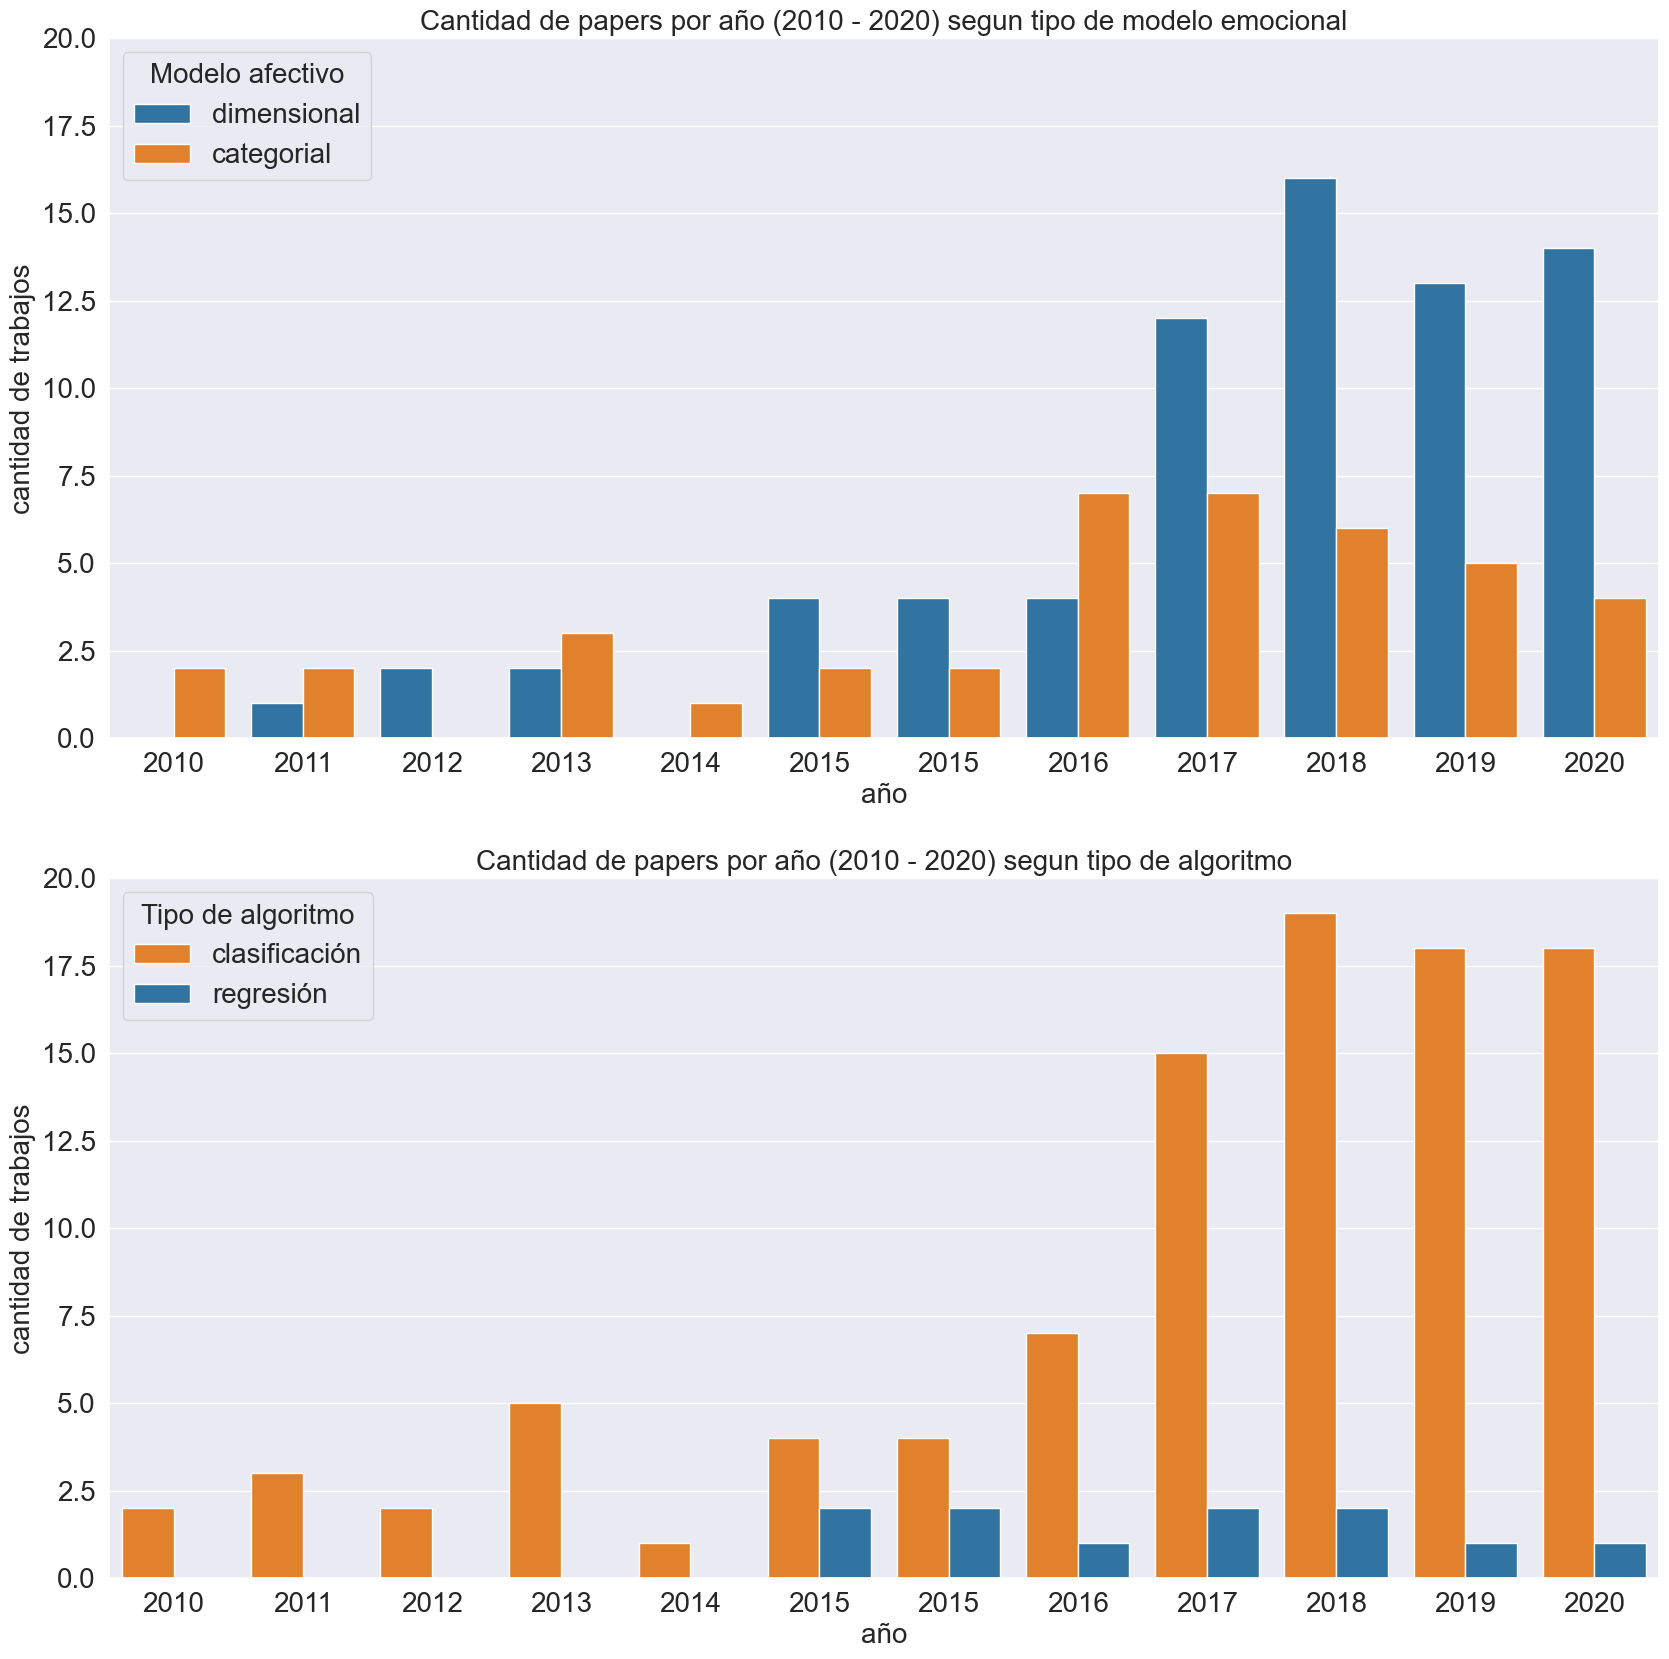

In [688]:
fig, axes = plt.subplots(2, 1)

ax1 = sns.countplot(x='year',
    data= df_statistical_learning_models_0, 
    hue='affective_model',
    palette = palette_es,
    order=category_order, 
    ax=axes[0])

ax2 = sns.countplot(x='year', 
    data= df_models, 
    hue='model',
    palette = palette_es,
    order = category_order, 
    ax=axes[1])

ax1.set_ylim([0, 20])
ax2.set_ylim([0, 20])

ax1.set_yticklabels(ax1.get_yticklabels(), size = 20)
ax2.set_yticklabels(ax2.get_yticklabels(), size = 20)
ax1.set_xticklabels(category_order,fontsize = 20)
ax2.set_xticklabels(category_order,fontsize = 20)

ax1.set_xlabel("año")
ax1.set_ylabel("cantidad de trabajos")
ax2.set_xlabel("año")
ax2.set_ylabel("cantidad de trabajos")

ax1.set_title("Cantidad de papers por año (2010 - 2020) segun tipo de modelo emocional", fontsize = 20)
ax2.set_title("Cantidad de papers por año (2010 - 2020) segun tipo de algoritmo", fontsize = 20)

ax1.legend(title='Modelo afectivo', title_fontsize=20, loc='upper left',fontsize=20)
ax2.legend(title='Tipo de algoritmo', title_fontsize=20, loc='upper left',fontsize=20)